# OCG613 Waves HW 6 

In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

In [2]:
purple = '#6a4c93'
blue = '#1982c4'
green = '#8ac926'
yellow = '#ffca3a'
red = '#FF595E'
pink = '#ff6289'

# Greens
caribbean_green = '#00cc99'
emerald = '#319177'
crayola_green = '#1cac78'
jade = '#00a86b'
kelly = '#4cbb17'
yellowgreen = '#9acd32'

# Blues
french_sky_blue = '#77b5fe'
opal = '#a8c3bc'
baby_blue = '#89cff0'
tiffany_blue = '#0abab5'
cornflower = '#6495ed'

# Pinks
hollywood_cerise = '#f400a1'
baker_miller = '#ff91af'
wild_strawberry = '#ff43a4'

# Purples
iris = '#5a4fcf'
orchid = '#9932cc'
amethyst = '#9966cc'
wisteria = '#c9a0dc'

# Oranges
neon_carrot = '#ffa343'
gamboge = '#e49b0f'
carrot = '#ed9121'

# Yellows
sunglow = '#ffcc33'
bitter_lemon = '#cae00d'
pantone_yellow = '#fedf00'

# Reds
candy_apple = '#e2062c'
carmine = '#eb4c42'
coquelicot = '#ff3800'

In [5]:
ds = xr.open_dataset("/Users/akbaskind/Desktop/cchdo_search_results/0_33RR20220430_ctd.nc")
dsP = ds

In [6]:
ds = xr.open_dataset("/Users/akbaskind/Desktop/ARCTIC/3_32PZ20020819_ctd.nc")
dsA = ds

In [7]:
ds = xr.open_dataset("/Users/akbaskind/Desktop/ATLANTIC/843_35TH20180611_ctd.nc")
dsAt = ds

In [8]:
ds = xr.open_dataset("/Users/akbaskind/Desktop/ATLANTIC/14_06MT11_5_ctd.nc")
dsAt2 = ds

In [9]:
ds = xr.open_dataset("/Users/akbaskind/Desktop/ATLANTIC/884_33AT20120419_ctd.nc")
dsAt3 = ds

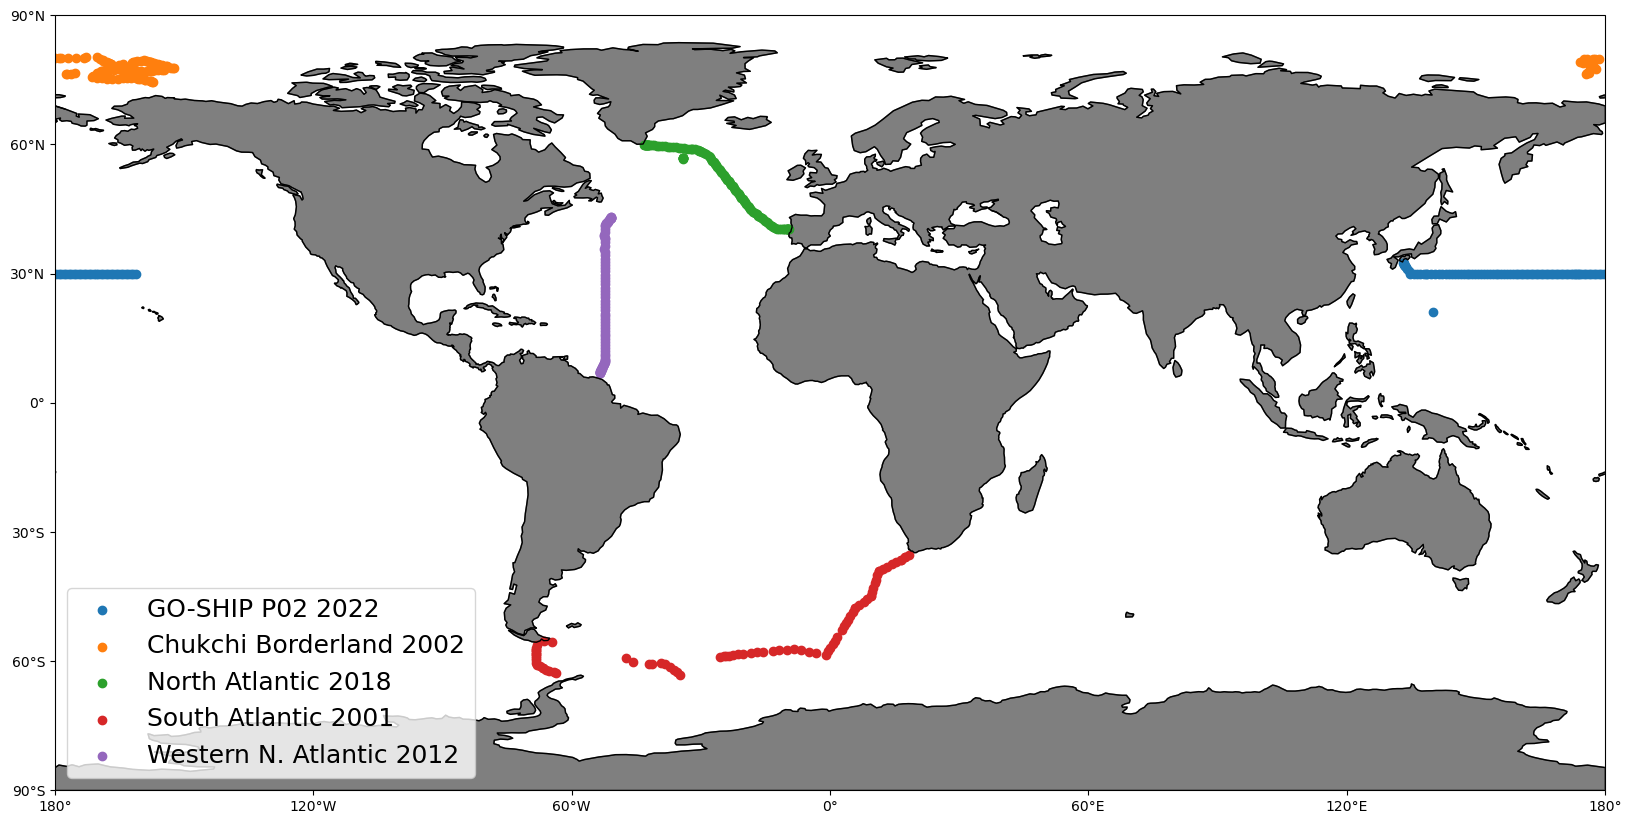

In [450]:
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy
fig, ax = plt.subplots(figsize = [20,20],subplot_kw={'projection':ccrs.PlateCarree()})
ax.scatter(dsP.longitude, dsP.latitude, label = 'GO-SHIP P02 2022')
ax.scatter(dsA.longitude, dsA.latitude, label = 'Chukchi Borderland 2002')
ax.scatter(dsAt.longitude, dsAt.latitude, label = 'North Atlantic 2018' )
ax.scatter(dsAt2.longitude, dsAt2.latitude, label = 'South Atlantic 2001')
ax.scatter(dsAt3.longitude, dsAt3.latitude, label = 'Western N. Atlantic 2012')
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, color = 'black', alpha = 0.5)
ax.legend(fontsize = 18)

# Longitude labels
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

fig.savefig('/Users/akbaskind/Desktop/Waves/Nmap.png', bbox_inches='tight')

Text(0.5, 0.98, 'Pacific')

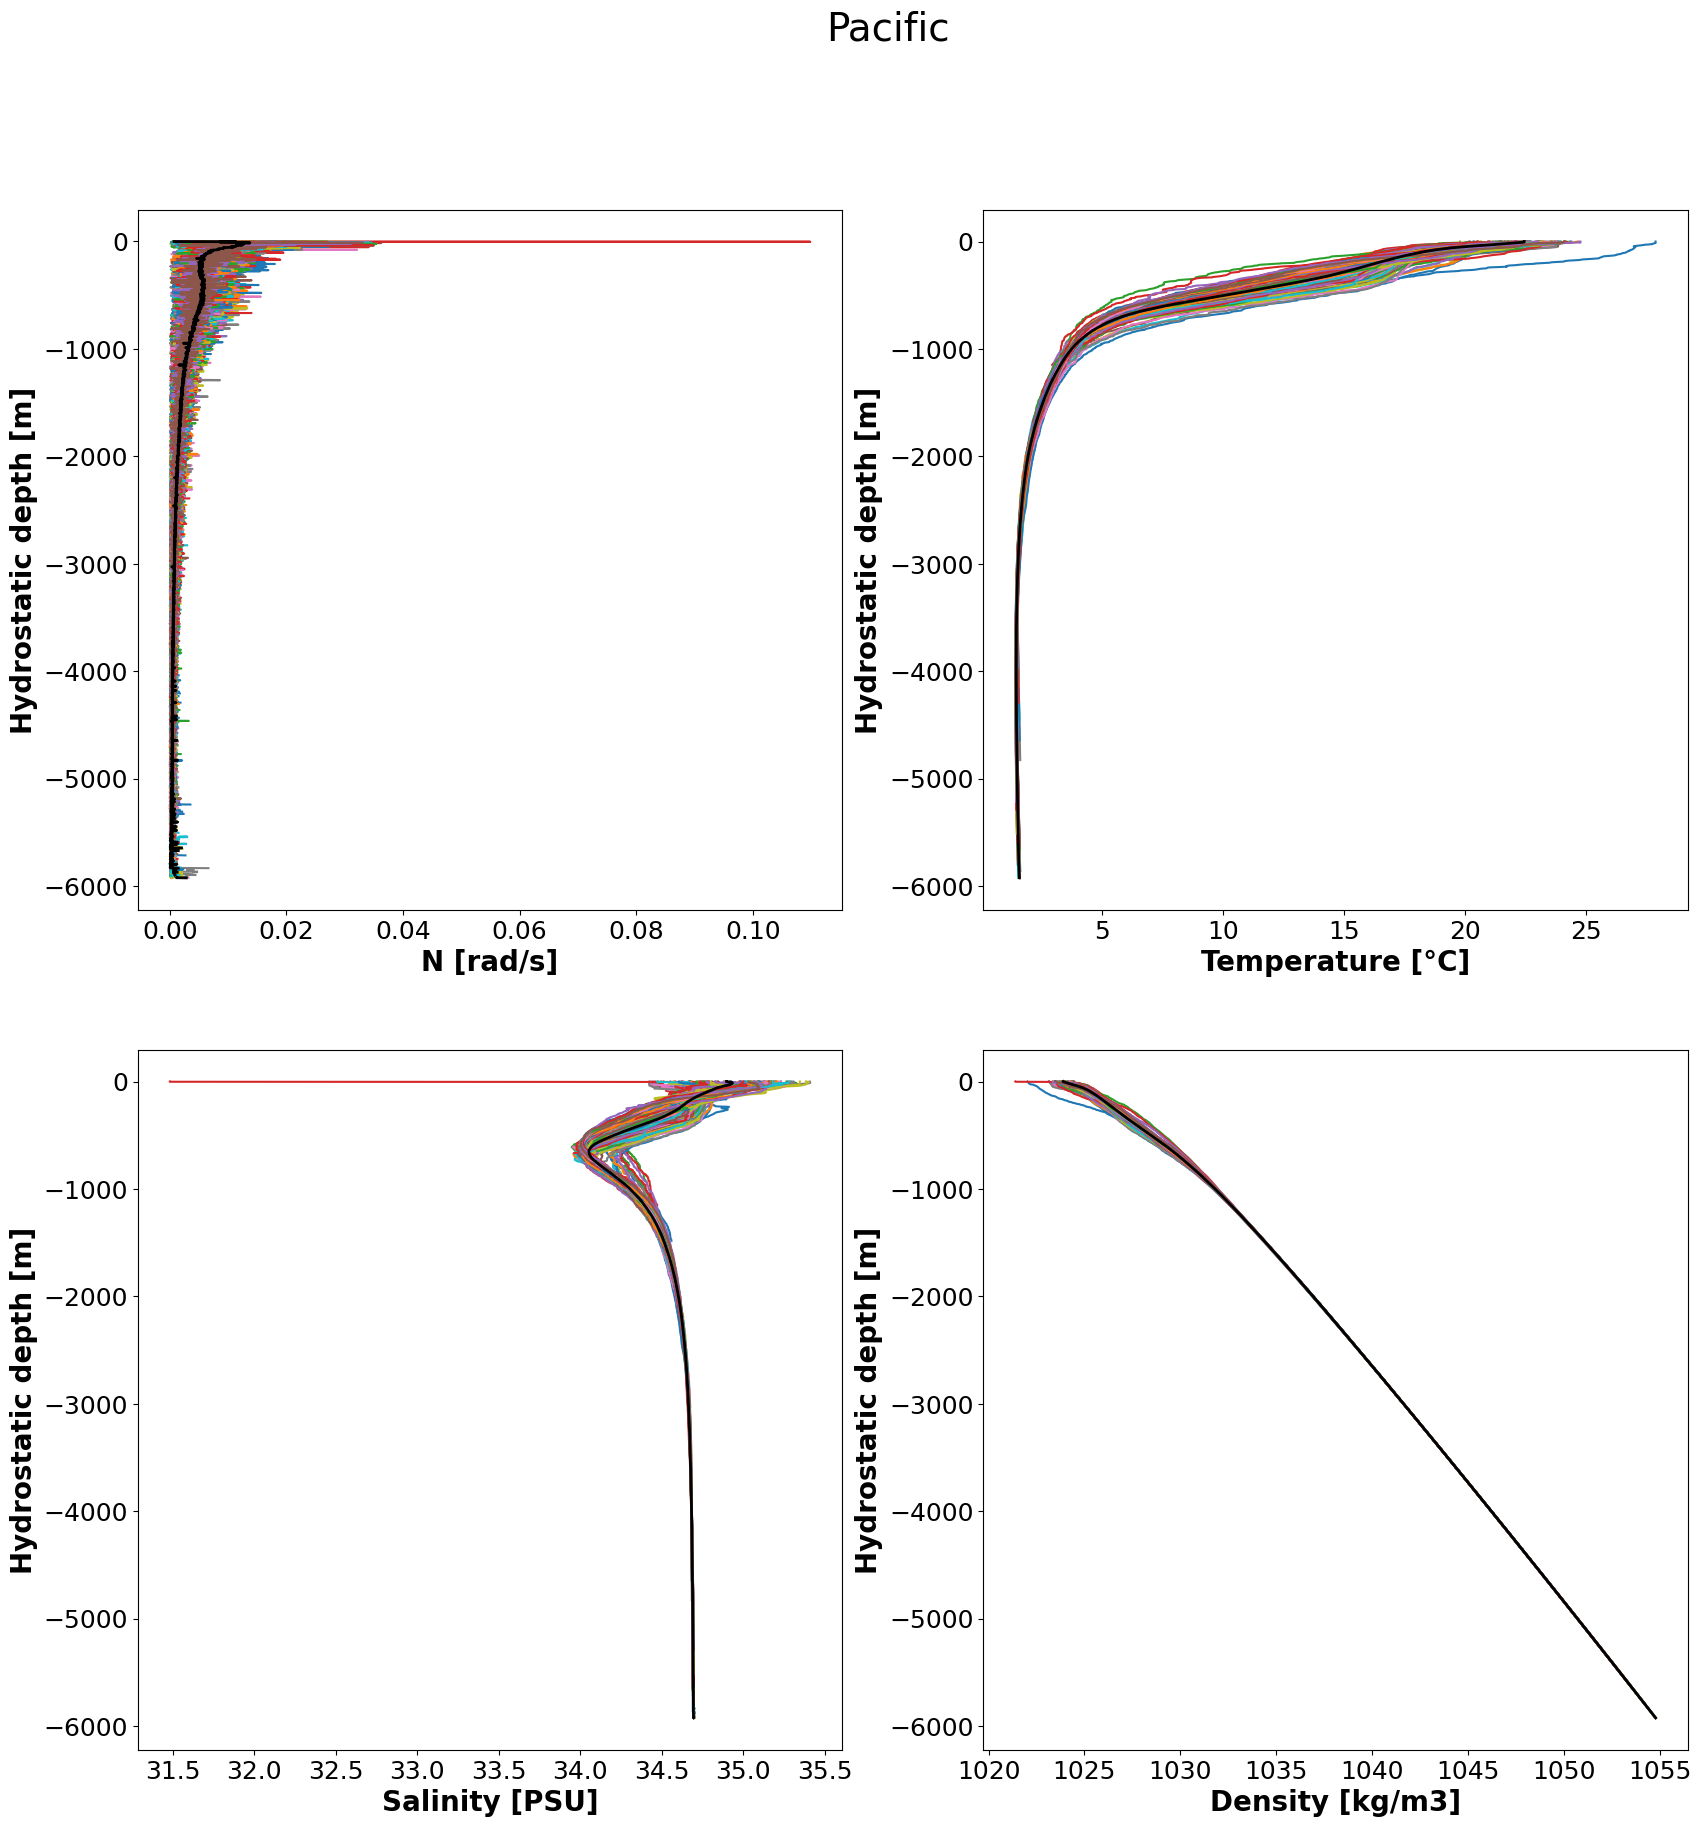

In [10]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ds = dsP
end = len(dsP['N_LEVELS'])-1
g = 9.81

axN = axarr[0]
axT = axarr[1]
axS = axarr[2]
axD = axarr[3]

for x in ds.N_PROF:
    item = ds.isel(N_PROF = x)
    lat = item.latitude
    # Salinity [PSU]
    S = item['ctd_salinity']
    # Temperature [degC]
    T = item['ctd_temperature']
    # Pressure [dbar]
    P = item['pressure']
    # Conservative temperature [degC]
    consT = gsw.conversions.CT_from_t(S,T,P)
    # Density [kg/m3]
    rho = gsw.density.rho(S, consT, P)
    # Depth from hydrostasis: P = rho*g*Z
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Z = (P*10000)/(rho * -g)
    # Brunt Vaisala & Pmid
    # From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
    N2, pmid = gsw.stability.Nsquared(S, consT, P, lat = lat)
    N = np.sqrt(N2)
    # Density at midpoints
    rho_mid = (rho[1:] + rho[:-1]) / 2
    # Depth at midpoints
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Zmid = (pmid*10000)/(rho_mid * -g)
    axN.plot(N,Zmid)
    axD.plot(rho,Z)
    axT.plot(T,Z)
    axS.plot(S,Z)
    
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)
axN.plot(N,Zmid, lw = 2, color = 'k')
axD.plot(rho,Z, lw = 2, color = 'k')
axT.plot(T,Z, lw = 2, color = 'k')
axS.plot(S,Z, lw = 2, color = 'k')

axN.set_xlabel('N [rad/s]', fontsize = 20, fontweight = 'bold')
axD.set_xlabel('Density [kg/m3]', fontsize = 20, fontweight = 'bold')
axS.set_xlabel('Salinity [PSU]', fontsize = 20, fontweight = 'bold')
axT.set_xlabel('Temperature [°C]', fontsize = 20, fontweight = 'bold')

for ax in axarr:
    # ax.set_xlabel('DIC$_{bio}$ [mmolC/m$^3$]', fontsize = 20, fontweight = 'bold')
    ax.set_ylabel('Hydrostatic depth [m]', fontsize = 20, fontweight = 'bold')
    ax.tick_params('y',labelsize = 18)
    ax.tick_params('x',labelsize = 18)
    
fig.suptitle('Pacific', fontsize = 28)
# fig.savefig('/Users/akbaskind/Desktop/Waves/Pac1.png', bbox_inches='tight')

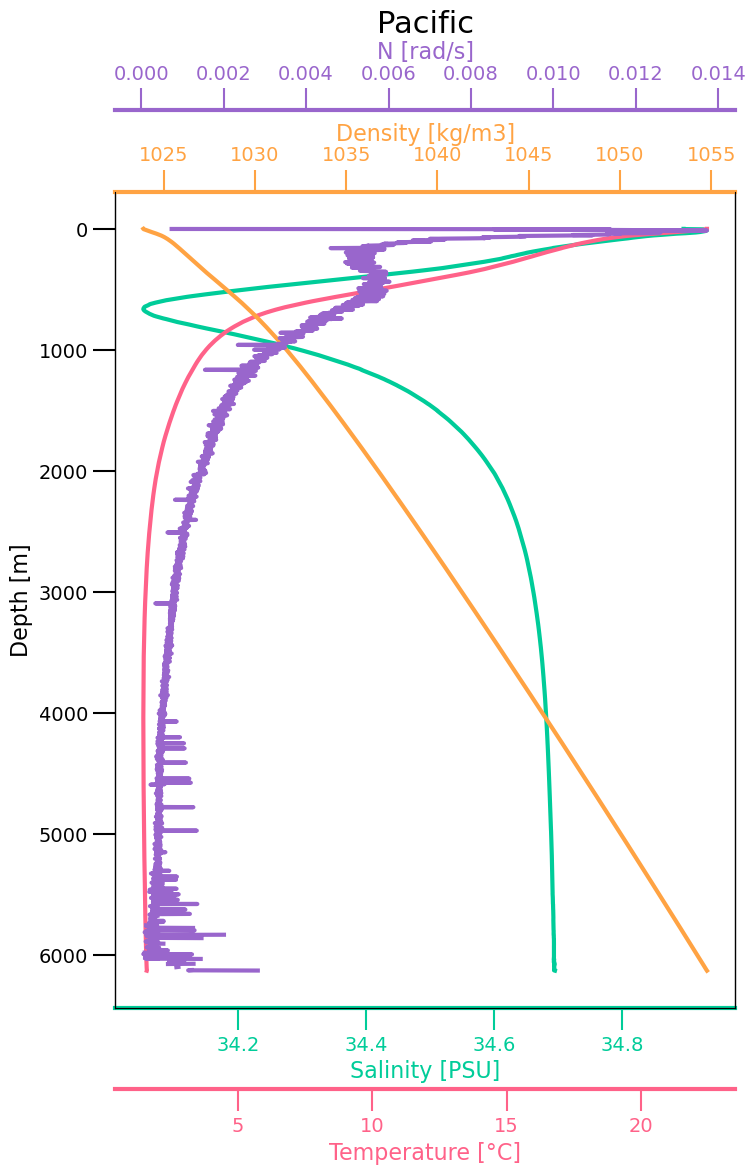

In [12]:
fig = plt.figure(figsize = [8,12])
ax1 = fig.add_subplot(111)
ax1.invert_yaxis()
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

ds = dsP
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)

X1 = S
X2 = T
X3 = rho
X4 = N

ax1.plot(X1,P, c = caribbean_green, lw = 3)
ax2.plot(X2,P, c = pink, lw = 3)
ax3.plot(X3,P, c = neon_carrot, lw = 3)
ax4.plot(X4,pmid, c = amethyst, lw = 3)
ax1.set_title('Pacific', fontsize = 22)

p1 = ax1.set_xlabel("Salinity [PSU]", color = caribbean_green, fontsize = 16)
p2 = ax2.set_xlabel("Temperature [°C]", color = pink, fontsize = 16)
p3 = ax3.set_xlabel("Density [kg/m3]", color = neon_carrot, fontsize = 16)
p4 = ax4.set_xlabel("N [rad/s]", color = amethyst, fontsize = 16)
ax1.set_ylabel('Depth [m]', fontsize = 16)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))
ax4.spines["top"].set_position(("axes", 1.1))

tkw = dict(labelsize = 14, size=16, width=1.5)
ax1.tick_params(axis='x', colors=caribbean_green, **tkw)
ax1.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='x', colors=pink, **tkw)
ax3.tick_params(axis='x', colors=neon_carrot, **tkw)
ax4.tick_params(axis='x', colors=amethyst, **tkw)

ax1.spines['bottom'].set_color(caribbean_green)
ax1.spines['bottom'].set_linewidth(3)
ax2.spines['bottom'].set_color(pink)
ax2.spines['bottom'].set_linewidth(3)
ax3.spines['top'].set_color(neon_carrot)
ax3.spines['top'].set_linewidth(3)
ax4.spines['top'].set_color(amethyst)
ax4.spines['top'].set_linewidth(3)

# fig.savefig('/Users/akbaskind/Desktop/Waves/Pac2.png', bbox_inches='tight')


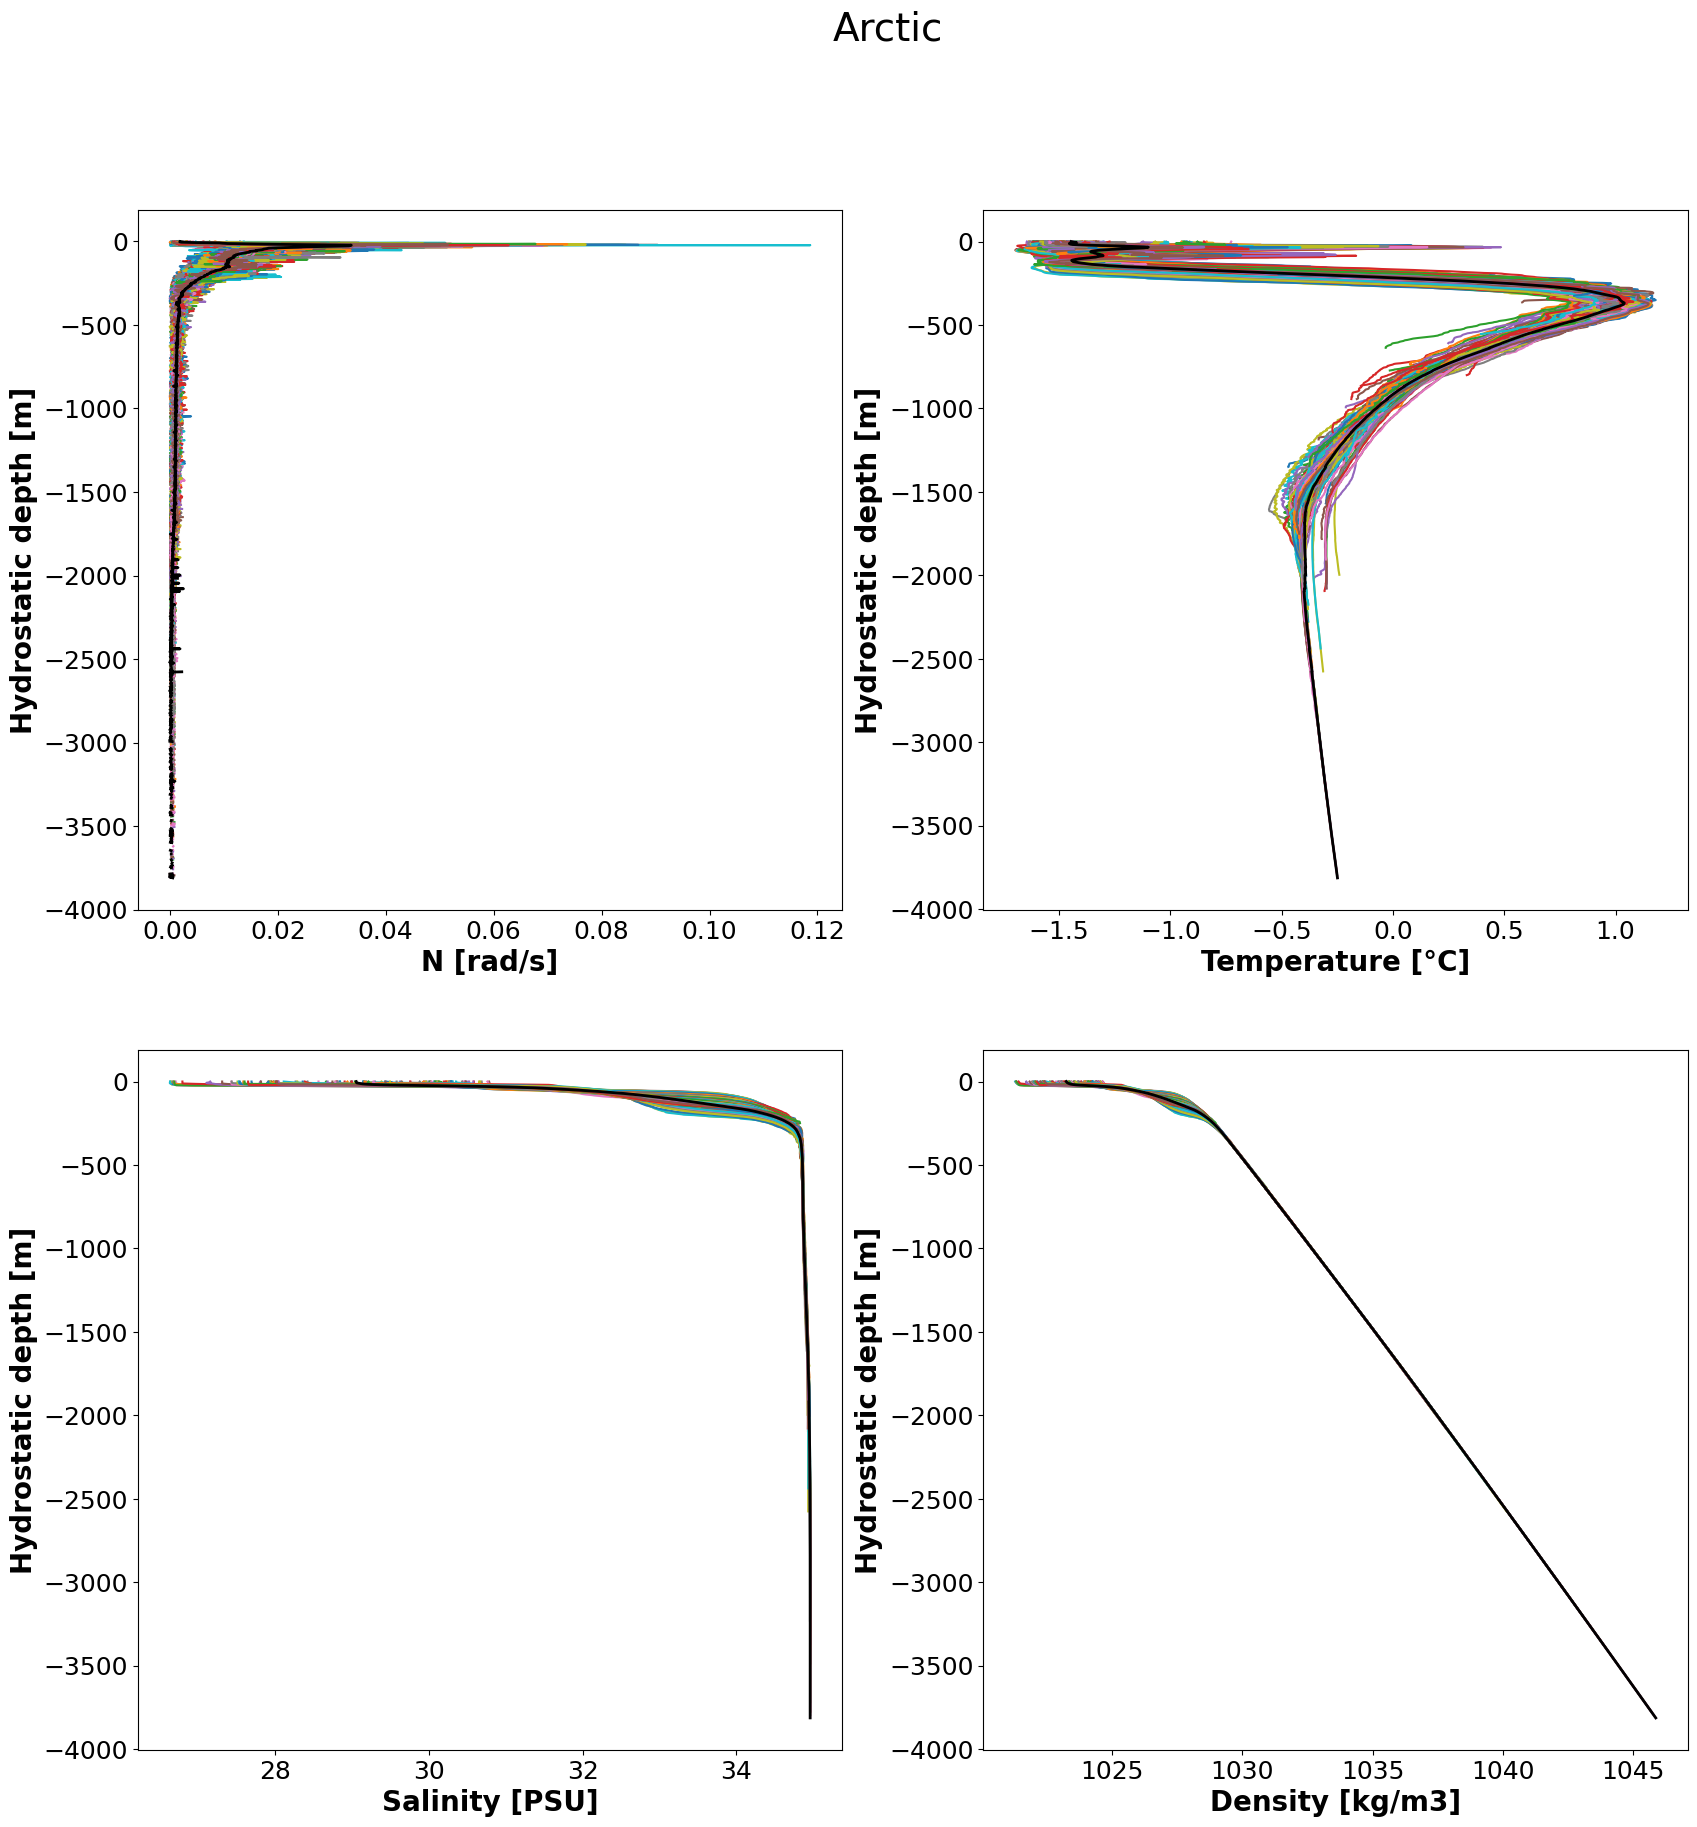

In [453]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ds = dsA
g = 9.81

axN = axarr[0]
axT = axarr[1]
axS = axarr[2]
axD = axarr[3]

for x in ds.N_PROF:
    item = ds.isel(N_PROF = x)
    lat = item.latitude
    # Salinity [PSU]
    S = item['ctd_salinity']
    # Temperature [degC]
    T = item['ctd_temperature']
    # Pressure [dbar]
    P = item['pressure']
    # Conservative temperature [degC]
    consT = gsw.conversions.CT_from_t(S,T,P)
    # Density [kg/m3]
    rho = gsw.density.rho(S, consT, P)
    # Depth from hydrostasis: P = rho*g*Z
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Z = (P*10000)/(rho * -g)
    # Brunt Vaisala & Pmid
    # From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
    N2, pmid = gsw.stability.Nsquared(S, consT, P, lat = lat)
    N = np.sqrt(N2)
    # Density at midpoints
    rho_mid = (rho[1:] + rho[:-1]) / 2
    # Depth at midpoints
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Zmid = (pmid*10000)/(rho_mid * -g)
    axN.plot(N,Zmid)
    axD.plot(rho,Z)
    axT.plot(T,Z)
    axS.plot(S,Z)
    
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)
axN.plot(N,Zmid, lw = 2, color = 'k')
axD.plot(rho,Z, lw = 2, color = 'k')
axT.plot(T,Z, lw = 2, color = 'k')
axS.plot(S,Z, lw = 2, color = 'k')

axN.set_xlabel('N [rad/s]', fontsize = 20, fontweight = 'bold')
axD.set_xlabel('Density [kg/m3]', fontsize = 20, fontweight = 'bold')
axS.set_xlabel('Salinity [PSU]', fontsize = 20, fontweight = 'bold')
axT.set_xlabel('Temperature [°C]', fontsize = 20, fontweight = 'bold')

for ax in axarr:
    # ax.set_xlabel('DIC$_{bio}$ [mmolC/m$^3$]', fontsize = 20, fontweight = 'bold')
    ax.set_ylabel('Hydrostatic depth [m]', fontsize = 20, fontweight = 'bold')
    ax.tick_params('y',labelsize = 18)
    ax.tick_params('x',labelsize = 18)
    
fig.suptitle('Arctic', fontsize = 28)
fig.savefig('/Users/akbaskind/Desktop/Waves/Arctic1.png', bbox_inches='tight')

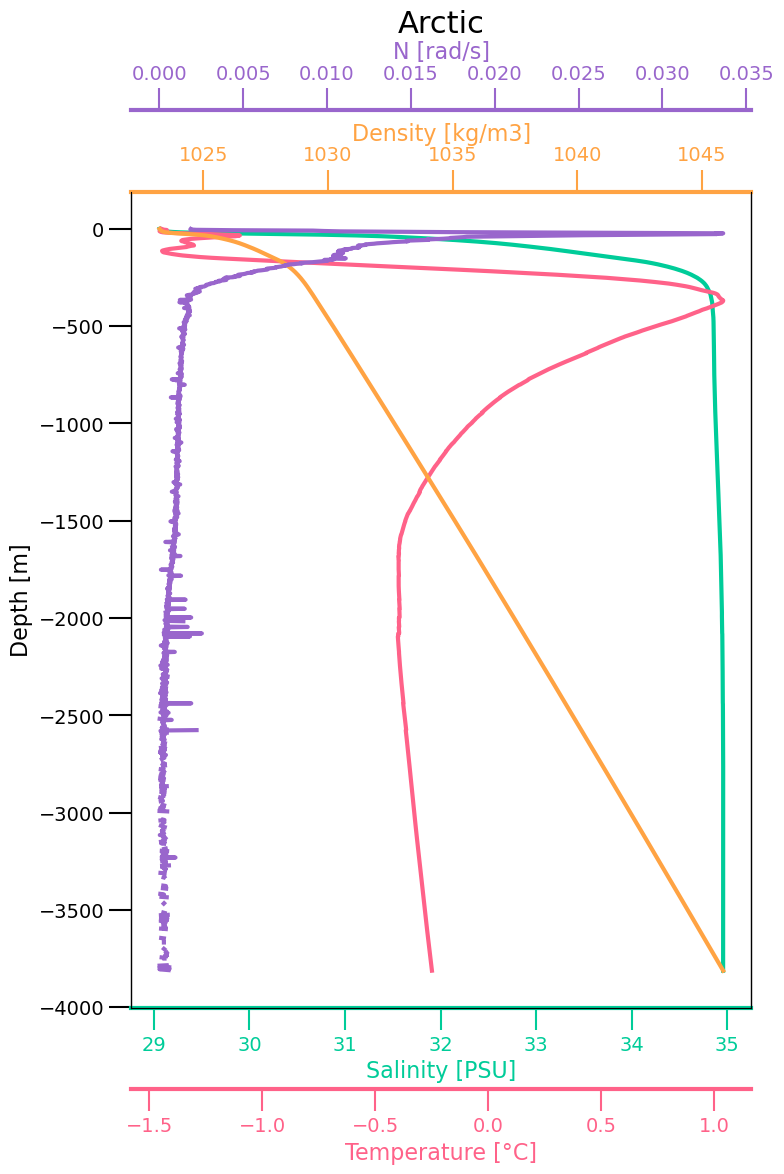

In [454]:
fig = plt.figure(figsize = [8,12])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

ds = dsA
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)

X1 = S
X2 = T
X3 = rho
X4 = N

ax1.plot(X1,Z, c = caribbean_green, lw = 3)
ax2.plot(X2,Z, c = pink, lw = 3)
ax3.plot(X3,Z, c = neon_carrot, lw = 3)
ax4.plot(X4,Zmid, c = amethyst, lw = 3)
ax1.set_title('Arctic', fontsize = 22)

p1 = ax1.set_xlabel("Salinity [PSU]", color = caribbean_green, fontsize = 16)
p2 = ax2.set_xlabel("Temperature [°C]", color = pink, fontsize = 16)
p3 = ax3.set_xlabel("Density [kg/m3]", color = neon_carrot, fontsize = 16)
p4 = ax4.set_xlabel("N [rad/s]", color = amethyst, fontsize = 16)
ax1.set_ylabel('Depth [m]', fontsize = 16)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))
ax4.spines["top"].set_position(("axes", 1.1))

tkw = dict(labelsize = 14, size=16, width=1.5)
ax1.tick_params(axis='x', colors=caribbean_green, **tkw)
ax1.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='x', colors=pink, **tkw)
ax3.tick_params(axis='x', colors=neon_carrot, **tkw)
ax4.tick_params(axis='x', colors=amethyst, **tkw)

ax1.spines['bottom'].set_color(caribbean_green)
ax1.spines['bottom'].set_linewidth(3)
ax2.spines['bottom'].set_color(pink)
ax2.spines['bottom'].set_linewidth(3)
ax3.spines['top'].set_color(neon_carrot)
ax3.spines['top'].set_linewidth(3)
ax4.spines['top'].set_color(amethyst)
ax4.spines['top'].set_linewidth(3)

fig.savefig('/Users/akbaskind/Desktop/Waves/Arctic2.png', bbox_inches='tight')


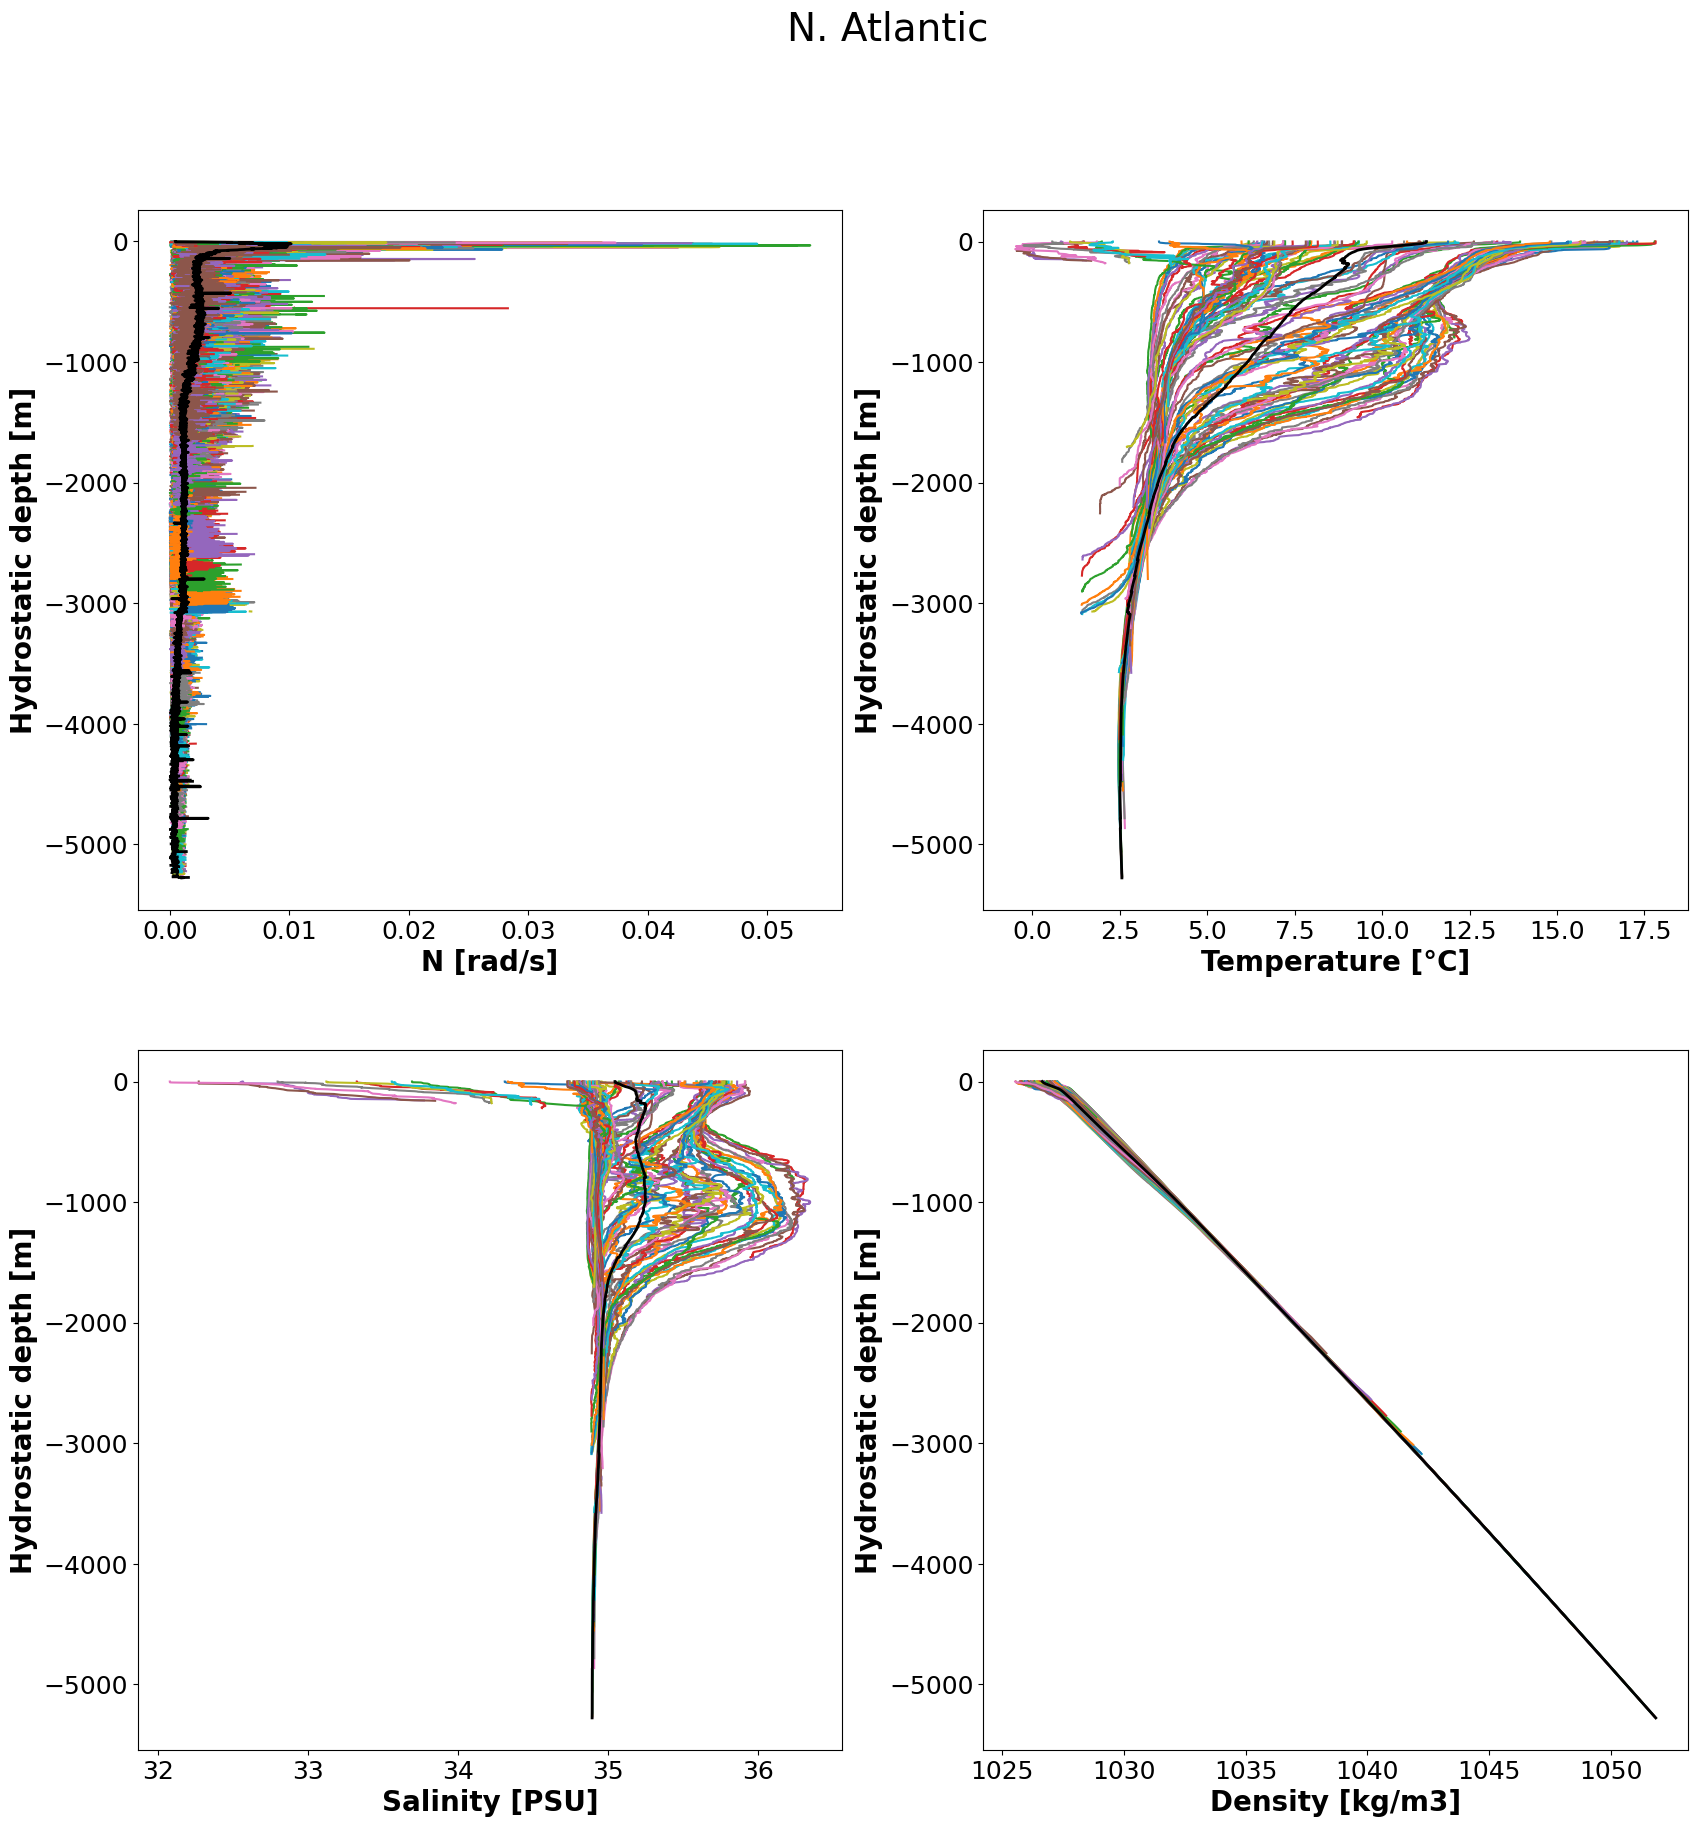

In [455]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ds = dsAt
g = 9.81

axN = axarr[0]
axT = axarr[1]
axS = axarr[2]
axD = axarr[3]

for x in ds.N_PROF:
    item = ds.isel(N_PROF = x)
    lat = item.latitude
    # Salinity [PSU]
    S = item['ctd_salinity']
    # Temperature [degC]
    T = item['ctd_temperature']
    # Pressure [dbar]
    P = item['pressure']
    # Conservative temperature [degC]
    consT = gsw.conversions.CT_from_t(S,T,P)
    # Density [kg/m3]
    rho = gsw.density.rho(S, consT, P)
    # Depth from hydrostasis: P = rho*g*Z
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Z = (P*10000)/(rho * -g)
    # Brunt Vaisala & Pmid
    # From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
    N2, pmid = gsw.stability.Nsquared(S, consT, P, lat = lat)
    N = np.sqrt(N2)
    # Density at midpoints
    rho_mid = (rho[1:] + rho[:-1]) / 2
    # Depth at midpoints
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Zmid = (pmid*10000)/(rho_mid * -g)
    axN.plot(N,Zmid)
    axD.plot(rho,Z)
    axT.plot(T,Z)
    axS.plot(S,Z)
    
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)
axN.plot(N,Zmid, lw = 2, color = 'k')
axD.plot(rho,Z, lw = 2, color = 'k')
axT.plot(T,Z, lw = 2, color = 'k')
axS.plot(S,Z, lw = 2, color = 'k')

axN.set_xlabel('N [rad/s]', fontsize = 20, fontweight = 'bold')
axD.set_xlabel('Density [kg/m3]', fontsize = 20, fontweight = 'bold')
axS.set_xlabel('Salinity [PSU]', fontsize = 20, fontweight = 'bold')
axT.set_xlabel('Temperature [°C]', fontsize = 20, fontweight = 'bold')

for ax in axarr:
    # ax.set_xlabel('DIC$_{bio}$ [mmolC/m$^3$]', fontsize = 20, fontweight = 'bold')
    ax.set_ylabel('Hydrostatic depth [m]', fontsize = 20, fontweight = 'bold')
    ax.tick_params('y',labelsize = 18)
    ax.tick_params('x',labelsize = 18)
    
fig.suptitle('N. Atlantic', fontsize = 28)
fig.savefig('/Users/akbaskind/Desktop/Waves/Natlantic1.png', bbox_inches='tight')

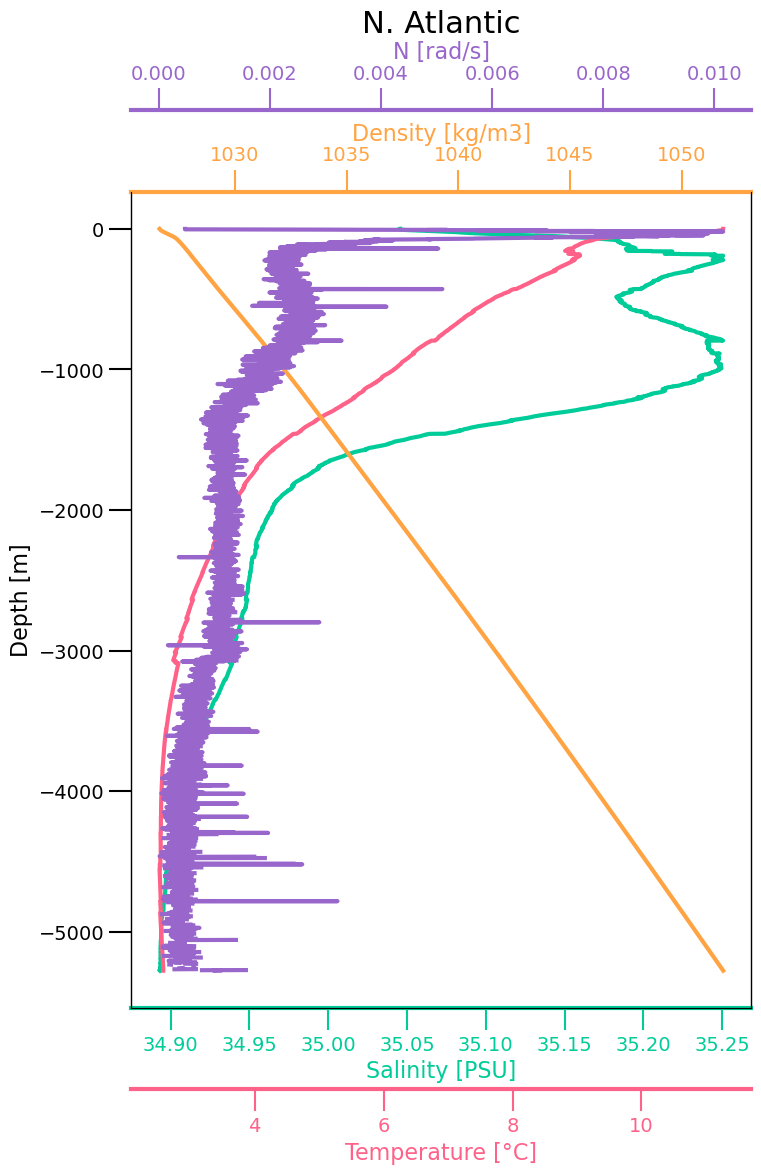

In [456]:
fig = plt.figure(figsize = [8,12])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

ds = dsAt
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)

X1 = S
X2 = T
X3 = rho
X4 = N

ax1.plot(X1,Z, c = caribbean_green, lw = 3)
ax2.plot(X2,Z, c = pink, lw = 3)
ax3.plot(X3,Z, c = neon_carrot, lw = 3)
ax4.plot(X4,Zmid, c = amethyst, lw = 3)
ax1.set_title('N. Atlantic', fontsize = 22)

p1 = ax1.set_xlabel("Salinity [PSU]", color = caribbean_green, fontsize = 16)
p2 = ax2.set_xlabel("Temperature [°C]", color = pink, fontsize = 16)
p3 = ax3.set_xlabel("Density [kg/m3]", color = neon_carrot, fontsize = 16)
p4 = ax4.set_xlabel("N [rad/s]", color = amethyst, fontsize = 16)
ax1.set_ylabel('Depth [m]', fontsize = 16)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))
ax4.spines["top"].set_position(("axes", 1.1))

tkw = dict(labelsize = 14, size=16, width=1.5)
ax1.tick_params(axis='x', colors=caribbean_green, **tkw)
ax1.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='x', colors=pink, **tkw)
ax3.tick_params(axis='x', colors=neon_carrot, **tkw)
ax4.tick_params(axis='x', colors=amethyst, **tkw)

ax1.spines['bottom'].set_color(caribbean_green)
ax1.spines['bottom'].set_linewidth(3)
ax2.spines['bottom'].set_color(pink)
ax2.spines['bottom'].set_linewidth(3)
ax3.spines['top'].set_color(neon_carrot)
ax3.spines['top'].set_linewidth(3)
ax4.spines['top'].set_color(amethyst)
ax4.spines['top'].set_linewidth(3)

fig.savefig('/Users/akbaskind/Desktop/Waves/Natlantic2.png', bbox_inches='tight')


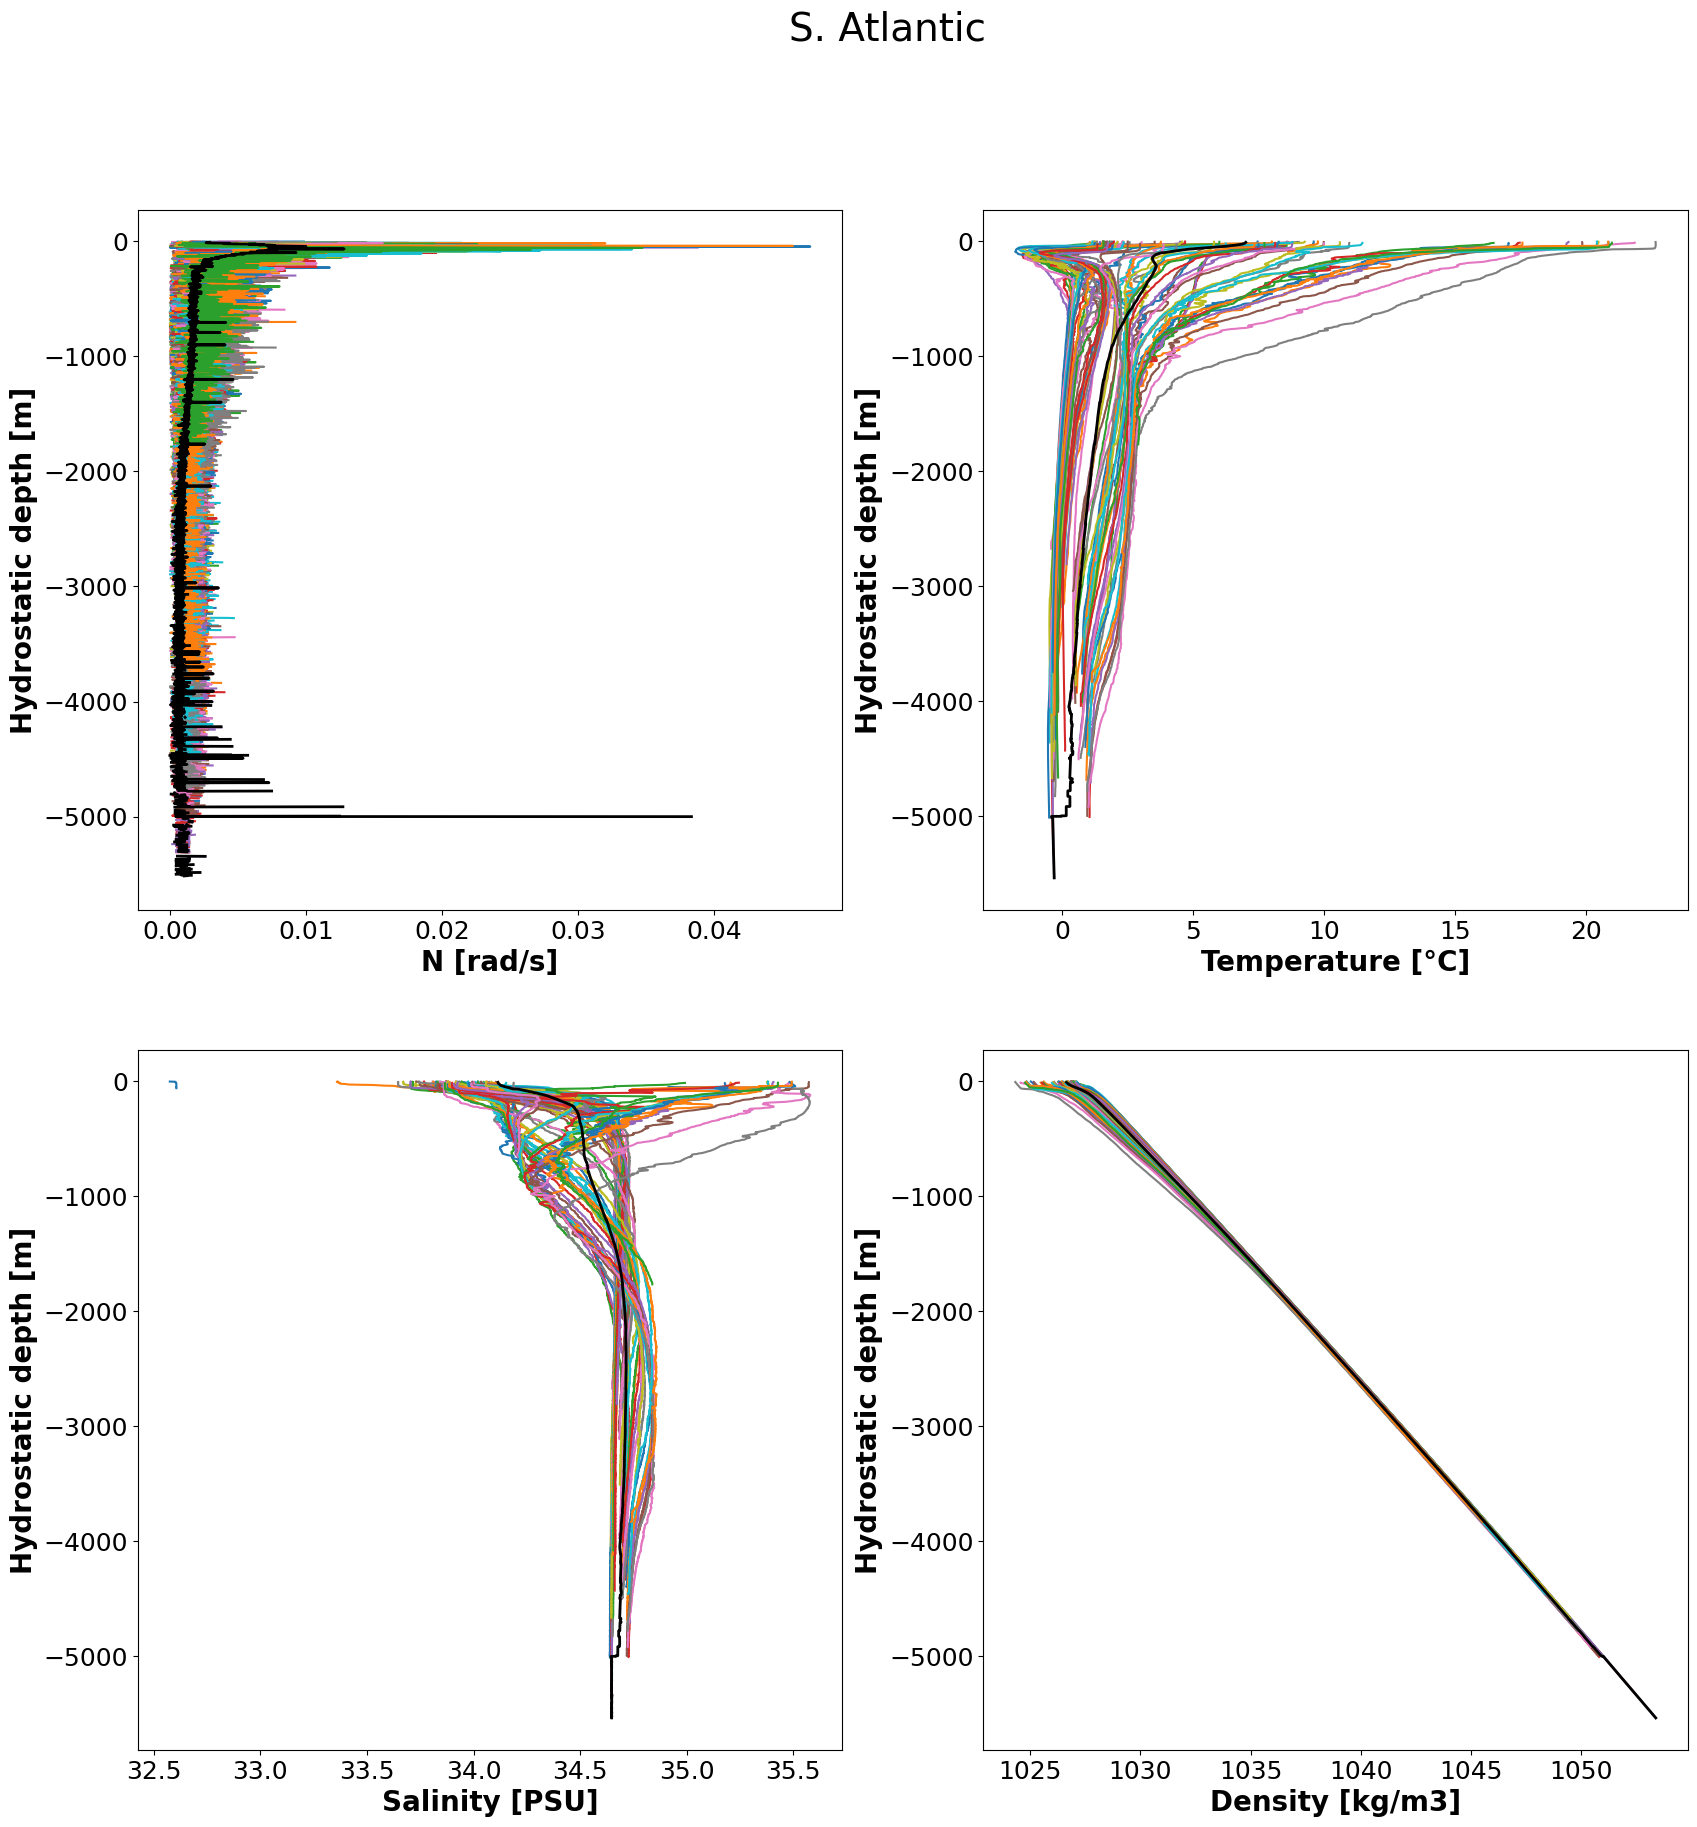

In [457]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ds = dsAt2
g = 9.81

axN = axarr[0]
axT = axarr[1]
axS = axarr[2]
axD = axarr[3]

for x in ds.N_PROF:
    item = ds.isel(N_PROF = x)
    lat = item.latitude
    # Salinity [PSU]
    S = item['ctd_salinity']
    # Temperature [degC]
    T = item['ctd_temperature_68']
    # Pressure [dbar]
    P = item['pressure']
    # Conservative temperature [degC]
    consT = gsw.conversions.CT_from_t(S,T,P)
    # Density [kg/m3]
    rho = gsw.density.rho(S, consT, P)
    # Depth from hydrostasis: P = rho*g*Z
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Z = (P*10000)/(rho * -g)
    # Brunt Vaisala & Pmid
    # From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
    N2, pmid = gsw.stability.Nsquared(S, consT, P, lat = lat)
    N = np.sqrt(N2)
    # Density at midpoints
    rho_mid = (rho[1:] + rho[:-1]) / 2
    # Depth at midpoints
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Zmid = (pmid*10000)/(rho_mid * -g)
    axN.plot(N,Zmid)
    axD.plot(rho,Z)
    axT.plot(T,Z)
    axS.plot(S,Z)
    
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature_68']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)
axN.plot(N,Zmid, lw = 2, color = 'k')
axD.plot(rho,Z, lw = 2, color = 'k')
axT.plot(T,Z, lw = 2, color = 'k')
axS.plot(S,Z, lw = 2, color = 'k')

axN.set_xlabel('N [rad/s]', fontsize = 20, fontweight = 'bold')
axD.set_xlabel('Density [kg/m3]', fontsize = 20, fontweight = 'bold')
axS.set_xlabel('Salinity [PSU]', fontsize = 20, fontweight = 'bold')
axT.set_xlabel('Temperature [°C]', fontsize = 20, fontweight = 'bold')

for ax in axarr:
    # ax.set_xlabel('DIC$_{bio}$ [mmolC/m$^3$]', fontsize = 20, fontweight = 'bold')
    ax.set_ylabel('Hydrostatic depth [m]', fontsize = 20, fontweight = 'bold')
    ax.tick_params('y',labelsize = 18)
    ax.tick_params('x',labelsize = 18)
    
fig.suptitle('S. Atlantic', fontsize = 28)
fig.savefig('/Users/akbaskind/Desktop/Waves/Satlantic1.png', bbox_inches='tight')

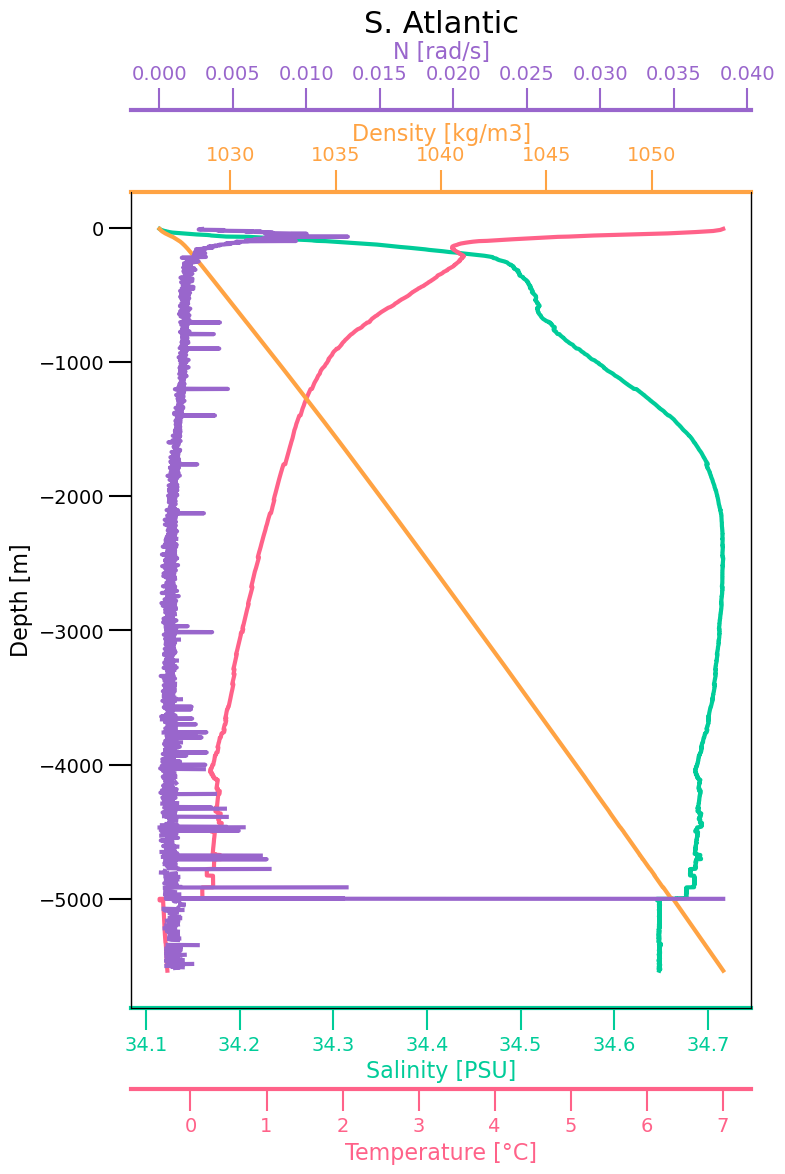

In [459]:
fig = plt.figure(figsize = [8,12])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

ds = dsAt2
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature_68']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)

X1 = S
X2 = T
X3 = rho
X4 = N

ax1.plot(X1,Z, c = caribbean_green, lw = 3)
ax2.plot(X2,Z, c = pink, lw = 3)
ax3.plot(X3,Z, c = neon_carrot, lw = 3)
ax4.plot(X4,Zmid, c = amethyst, lw = 3)
ax1.set_title('S. Atlantic', fontsize = 22)

p1 = ax1.set_xlabel("Salinity [PSU]", color = caribbean_green, fontsize = 16)
p2 = ax2.set_xlabel("Temperature [°C]", color = pink, fontsize = 16)
p3 = ax3.set_xlabel("Density [kg/m3]", color = neon_carrot, fontsize = 16)
p4 = ax4.set_xlabel("N [rad/s]", color = amethyst, fontsize = 16)
ax1.set_ylabel('Depth [m]', fontsize = 16)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))
ax4.spines["top"].set_position(("axes", 1.1))

tkw = dict(labelsize = 14, size=16, width=1.5)
ax1.tick_params(axis='x', colors=caribbean_green, **tkw)
ax1.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='x', colors=pink, **tkw)
ax3.tick_params(axis='x', colors=neon_carrot, **tkw)
ax4.tick_params(axis='x', colors=amethyst, **tkw)

ax1.spines['bottom'].set_color(caribbean_green)
ax1.spines['bottom'].set_linewidth(3)
ax2.spines['bottom'].set_color(pink)
ax2.spines['bottom'].set_linewidth(3)
ax3.spines['top'].set_color(neon_carrot)
ax3.spines['top'].set_linewidth(3)
ax4.spines['top'].set_color(amethyst)
ax4.spines['top'].set_linewidth(3)

fig.savefig('/Users/akbaskind/Desktop/Waves/Satlantic2.png', bbox_inches='tight')


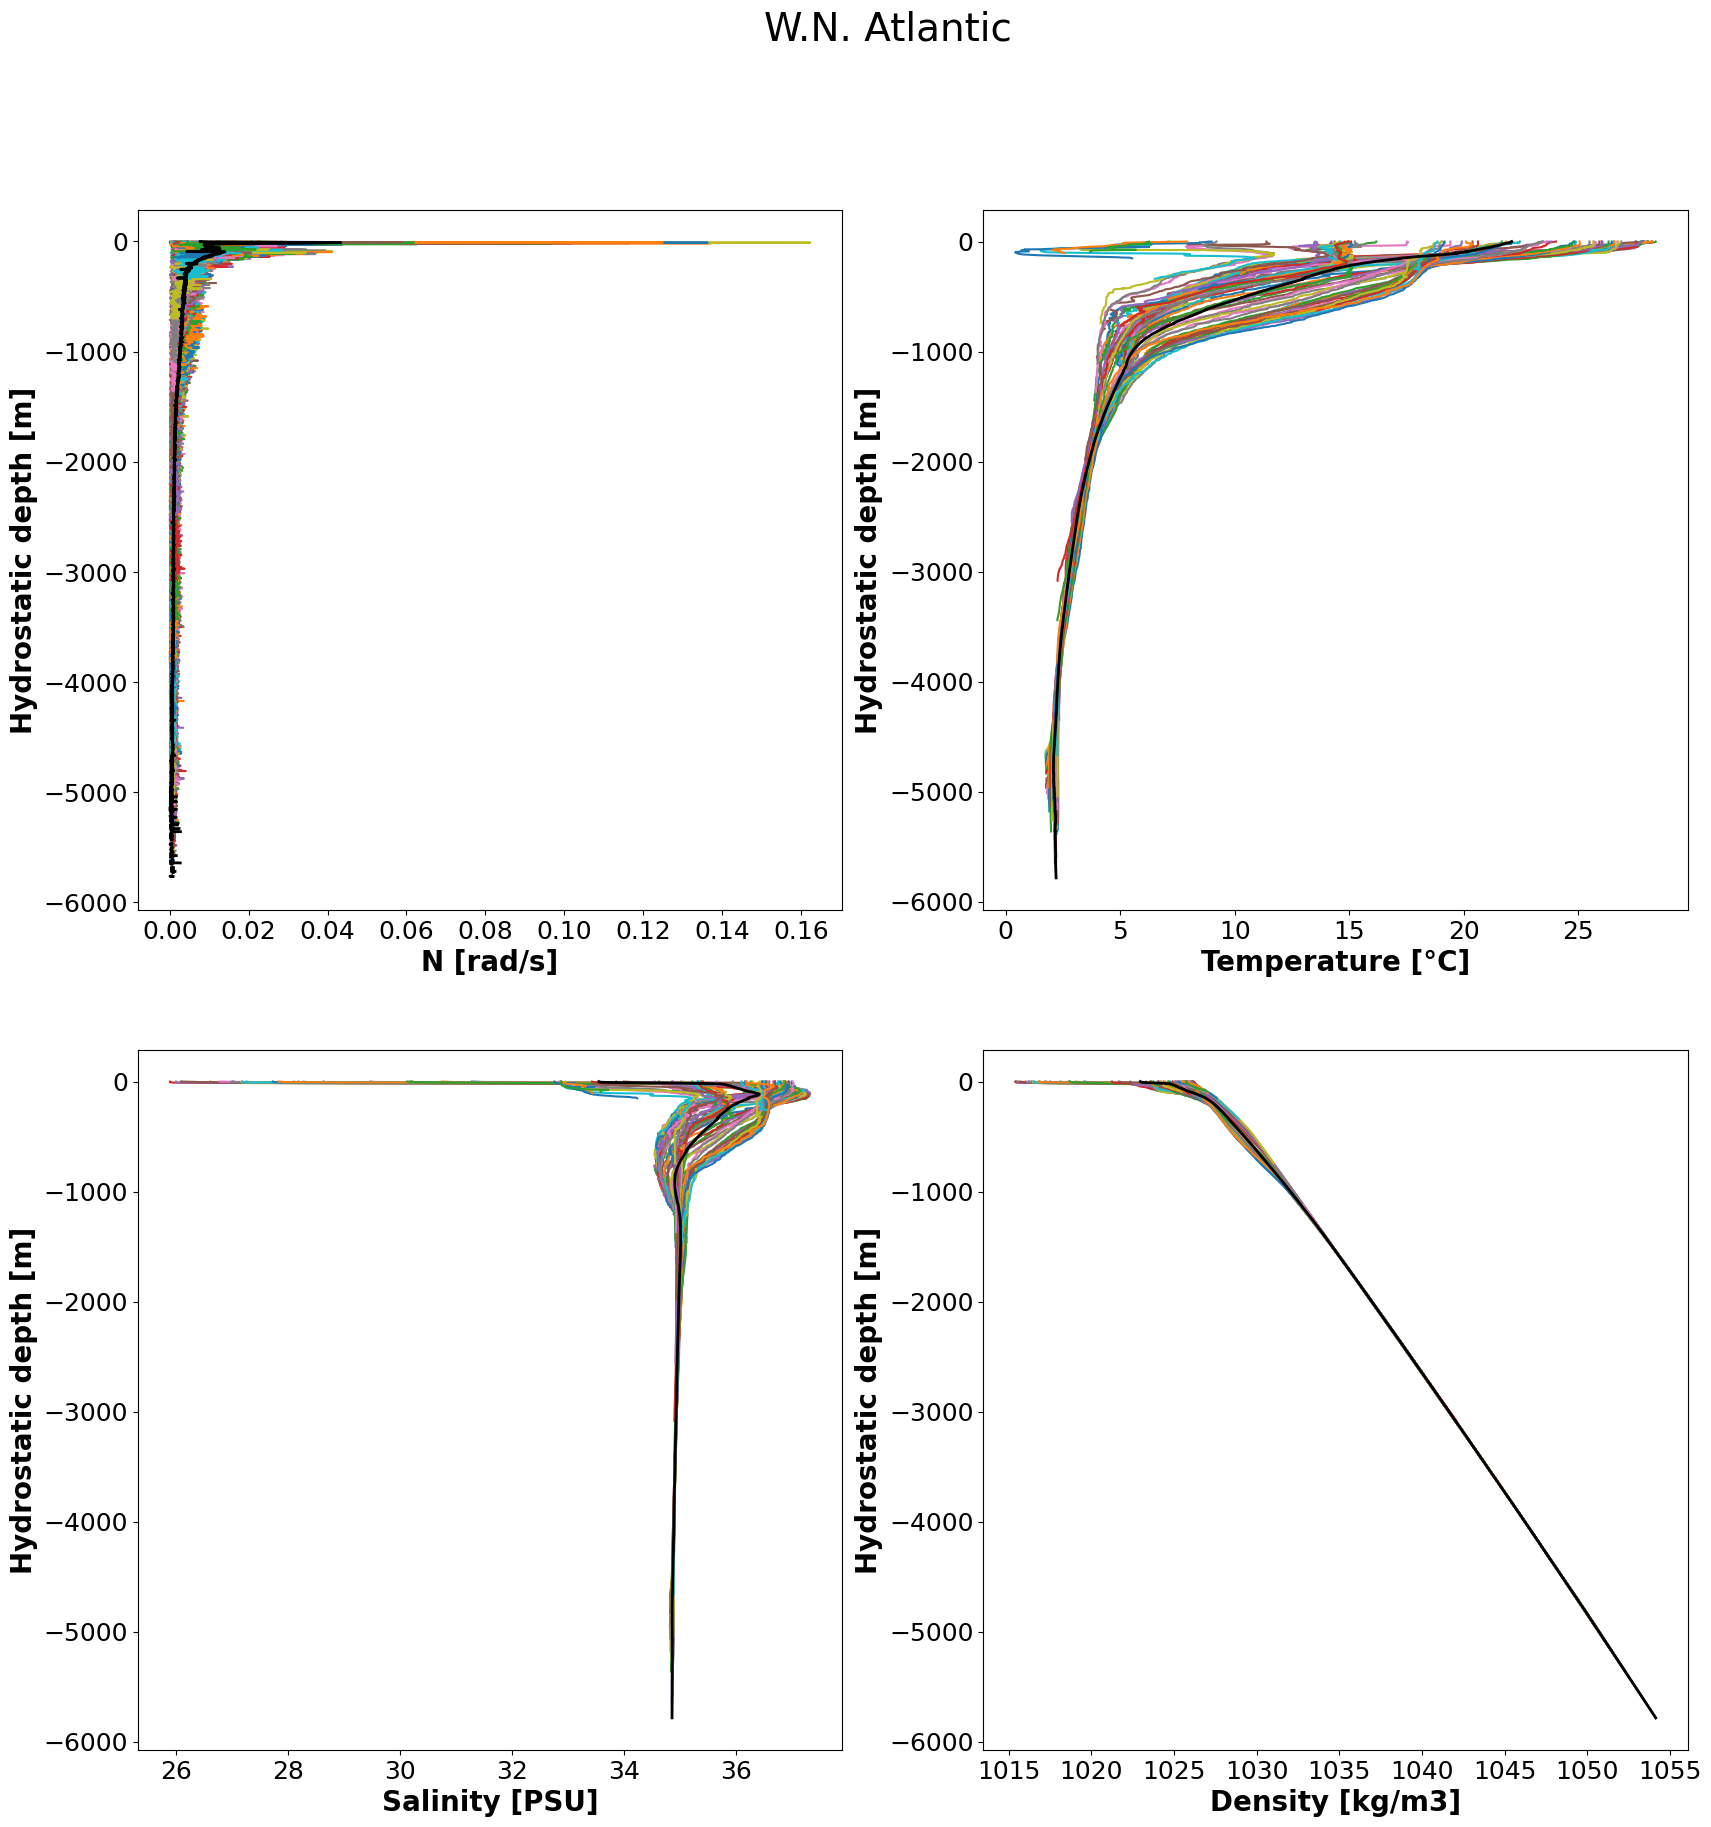

In [460]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

ds = dsAt3
g = 9.81

axN = axarr[0]
axT = axarr[1]
axS = axarr[2]
axD = axarr[3]

for x in ds.N_PROF:
    item = ds.isel(N_PROF = x)
    lat = item.latitude
    # Salinity [PSU]
    S = item['ctd_salinity']
    # Temperature [degC]
    T = item['ctd_temperature']
    # Pressure [dbar]
    P = item['pressure']
    # Conservative temperature [degC]
    consT = gsw.conversions.CT_from_t(S,T,P)
    # Density [kg/m3]
    rho = gsw.density.rho(S, consT, P)
    # Depth from hydrostasis: P = rho*g*Z
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Z = (P*10000)/(rho * -g)
    # Brunt Vaisala & Pmid
    # From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
    N2, pmid = gsw.stability.Nsquared(S, consT, P, lat = lat)
    N = np.sqrt(N2)
    # Density at midpoints
    rho_mid = (rho[1:] + rho[:-1]) / 2
    # Depth at midpoints
    # P converted from dbar to Pa: 1 dbar = 10000 Pa
    Zmid = (pmid*10000)/(rho_mid * -g)
    axN.plot(N,Zmid)
    axD.plot(rho,Z)
    axT.plot(T,Z)
    axS.plot(S,Z)
    
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)
axN.plot(N,Zmid, lw = 2, color = 'k')
axD.plot(rho,Z, lw = 2, color = 'k')
axT.plot(T,Z, lw = 2, color = 'k')
axS.plot(S,Z, lw = 2, color = 'k')

axN.set_xlabel('N [rad/s]', fontsize = 20, fontweight = 'bold')
axD.set_xlabel('Density [kg/m3]', fontsize = 20, fontweight = 'bold')
axS.set_xlabel('Salinity [PSU]', fontsize = 20, fontweight = 'bold')
axT.set_xlabel('Temperature [°C]', fontsize = 20, fontweight = 'bold')

for ax in axarr:
    # ax.set_xlabel('DIC$_{bio}$ [mmolC/m$^3$]', fontsize = 20, fontweight = 'bold')
    ax.set_ylabel('Hydrostatic depth [m]', fontsize = 20, fontweight = 'bold')
    ax.tick_params('y',labelsize = 18)
    ax.tick_params('x',labelsize = 18)
    
fig.suptitle('W.N. Atlantic', fontsize = 28)
fig.savefig('/Users/akbaskind/Desktop/Waves/WNatlantic1.png', bbox_inches='tight')

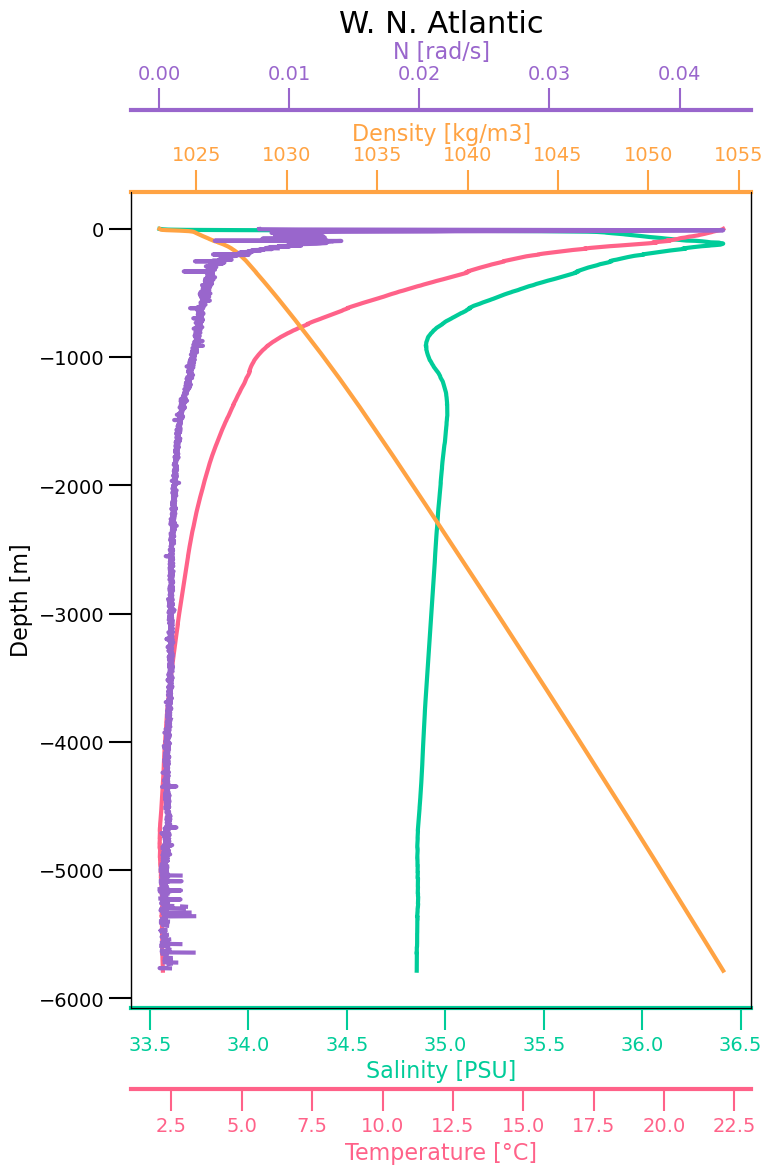

In [461]:
fig = plt.figure(figsize = [8,12])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

ds = dsAt3
# Mean of all sites of cruise
item = ds.mean('N_PROF')
# Salinity [PSU]
S = item['ctd_salinity']
# Temperature [degC]
T = item['ctd_temperature']
# Pressure [dbar]
P = ds.pressure.mean('N_PROF')
# Conservative temperature [degC]
consT = gsw.conversions.CT_from_t(S,T,P)
# Density [kg/m3]
rho = gsw.density.rho(S, consT, P)
rho_mid = (rho[1:] + rho[:-1]) / 2
# From gsw.stability.Nsquared(S [PSU], CT [degC], P [dbar])
N2, pmid = gsw.stability.Nsquared(S, consT, P)
N = np.sqrt(N2)
# Depth from hydrostasis: P = rho*g*Z
# P converted from dbar to Pa: 1 dbar = 10000 Pa
Z = (P*10000)/(rho * -g)
Zmid = (pmid*10000)/(rho_mid * -g)

X1 = S
X2 = T
X3 = rho
X4 = N

ax1.plot(X1,Z, c = caribbean_green, lw = 3)
ax2.plot(X2,Z, c = pink, lw = 3)
ax3.plot(X3,Z, c = neon_carrot, lw = 3)
ax4.plot(X4,Zmid, c = amethyst, lw = 3)
ax1.set_title('W. N. Atlantic', fontsize = 22)

p1 = ax1.set_xlabel("Salinity [PSU]", color = caribbean_green, fontsize = 16)
p2 = ax2.set_xlabel("Temperature [°C]", color = pink, fontsize = 16)
p3 = ax3.set_xlabel("Density [kg/m3]", color = neon_carrot, fontsize = 16)
p4 = ax4.set_xlabel("N [rad/s]", color = amethyst, fontsize = 16)
ax1.set_ylabel('Depth [m]', fontsize = 16)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))
ax4.spines["top"].set_position(("axes", 1.1))

tkw = dict(labelsize = 14, size=16, width=1.5)
ax1.tick_params(axis='x', colors=caribbean_green, **tkw)
ax1.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='x', colors=pink, **tkw)
ax3.tick_params(axis='x', colors=neon_carrot, **tkw)
ax4.tick_params(axis='x', colors=amethyst, **tkw)

ax1.spines['bottom'].set_color(caribbean_green)
ax1.spines['bottom'].set_linewidth(3)
ax2.spines['bottom'].set_color(pink)
ax2.spines['bottom'].set_linewidth(3)
ax3.spines['top'].set_color(neon_carrot)
ax3.spines['top'].set_linewidth(3)
ax4.spines['top'].set_color(amethyst)
ax4.spines['top'].set_linewidth(3)


fig.savefig('/Users/akbaskind/Desktop/Waves/WNatlantic2.png', bbox_inches='tight')

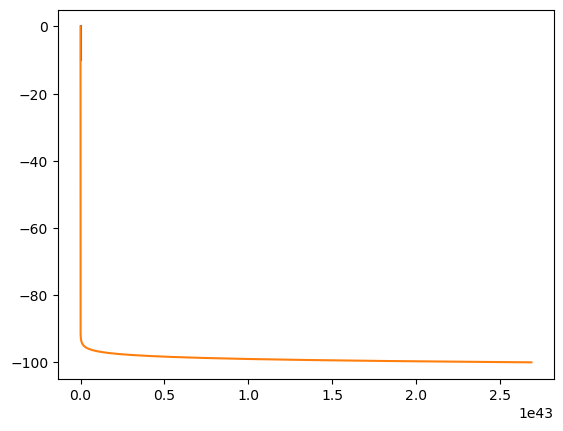

In [310]:
# Long, shallow waves
rho = 1025               # kg/m3
g = 9.8                  # m/s2
E0 = 1                   # m
H1 = 10                  # m
L1 = 1000           # m [wavelength]
k1 = 2 * np.pi / L1      # rad/m [wavenumber]
z1 = np.linspace(0,H1,100)
p1 = (np.cosh(k1* (z1 + H1))/np.cosh(k1*H1))

# short, deep waves
rho = 1025               # kg/m3
g = 9.8                  # m/s2
E0 = 1                   # m
H2 = 100                 # m
L2 = 2 * np.pi                   # m [wavelength]
k2 = 2 * np.pi / L2      # rad/m [wavenumber]
z2 = np.linspace(0,H2,1000)
p2 = (np.cosh(k2 * (z2 + H2))/np.cosh(k2*H2))

fig,ax = plt.subplots()

ax.plot(p1,-z1)

ax.plot(p2,-z2)

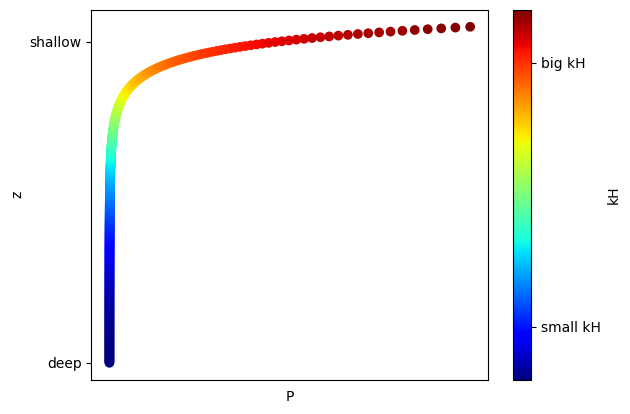

In [361]:
rho = 1              # kg/m3
g = 1                # m/s2
E0 = 1                   # m
H = np.linspace(0,400,1000)
k = np.linspace(0,10,1000)
z = np.linspace(0,5,1000)
p = rho * g * E0 * np.cosh(k*z + k*H)/np.cosh(k*H)
M = k*H
fig,ax = plt.subplots()
im = ax.scatter(p,z,c = M, cmap = 'jet')
cbar = plt.colorbar(im)
cbar.ax.set_yticks([100,600])
cbar.ax.set_yticklabels(['small kH','big kH'])
cbar.set_label('kH')
ax.set_ylabel('z')
ax.set_yticks([0,2])
ax.set_yticklabels(['deep','shallow'])
ax.set_xticks([])
ax.set_xlabel('P')
fig.savefig('/Users/akbaskind/Desktop/Waves/pe_Quiz2.png', bbox_inches='tight')

In [320]:
z

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

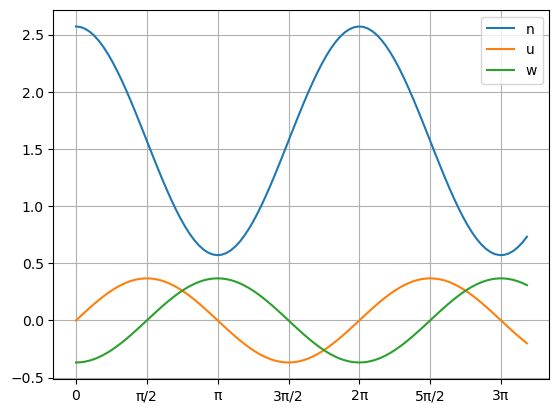

In [188]:
x = np.linspace(0,10,100)
z = np.linspace(0,10,100)
n = np.cos(x)
u = np.exp(-1) * np.sin(x)
w = -1 * np.exp(-1) * np.cos(x)

fig,ax = plt.subplots()
ax.plot(x,n + np.pi/2, label = 'n')
ax.plot(x,u, label = 'u')
ax.plot(x,w, label = 'w')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2,6*np.pi/2])
ax.set_xticklabels(['0','π/2','π','3π/2','2π','5π/2','3π'])
ax.legend()
plt.grid(True)

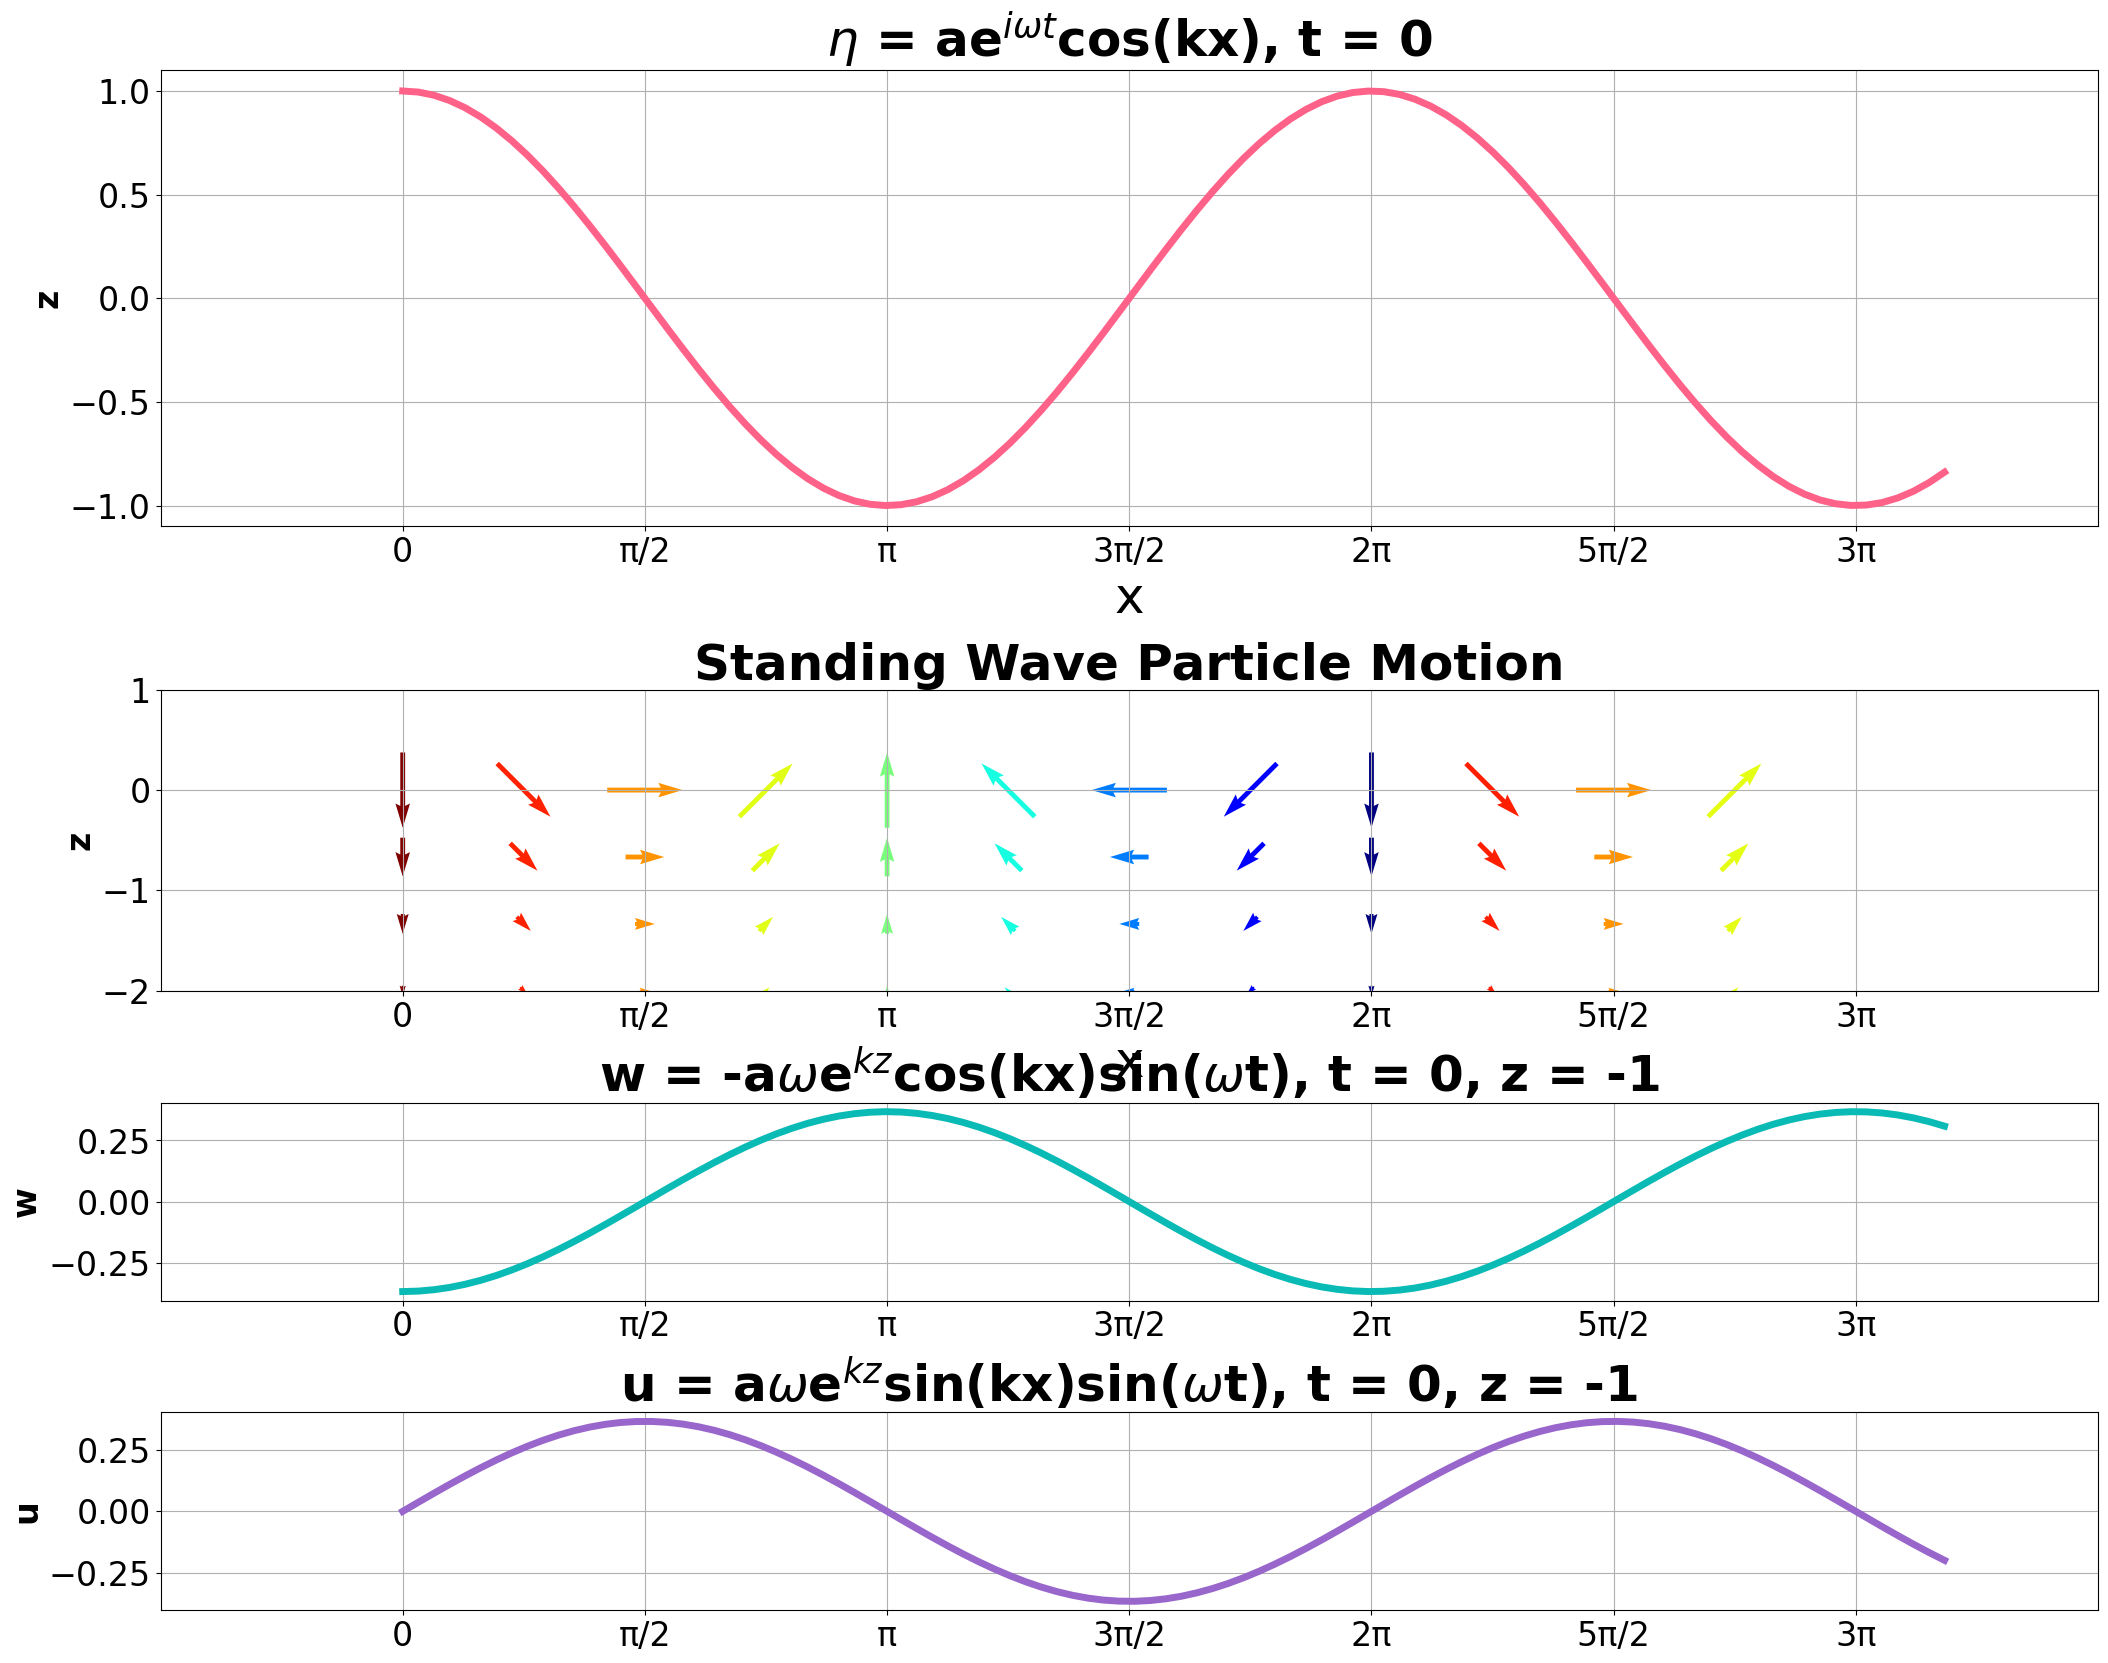

In [309]:
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
from matplotlib.colors import Normalize
fig = plt.figure(figsize = [25,20],tight_layout=True)
gs = gridspec.GridSpec(30, 1)
fig.tight_layout(pad=50.0)
W1 = 4
W = 24
pink = '#ff6289'
purple = '#9966cc'
blue = '#0abab5'


title = r'$\eta$ = ae$^{i\omega t}$cos(kx), t = 0'


# FIRST SUBPLOT: n
ax = fig.add_subplot(gs[0:9, 0])
x = np.linspace(0,10,100)
z = np.linspace(0,10,100)
n = np.cos(x)
ax.plot(x,n, lw = 5, c = pink, label = 'n')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2,6*np.pi/2])
ax.set_xticklabels(['0','π/2','π','3π/2','2π','5π/2','3π'])

ax.tick_params('x',labelsize = 24)
ax.tick_params('y',labelsize = 24)
ax.set_ylabel('z', fontsize = 24, fontweight = 'bold')
ax.set_xlabel('x', fontsize = 36)
ax.set_xlim([-np.pi/2,(7/2)*np.pi])
ax.set_title(title, fontsize = 36, fontweight = 'bold')
plt.grid(True)



# SECOND SUBPLOT: PH TIME SERIES*******************************************************************************
 

title = r'u = a$\omega$e$^{kz}$sin(kx)sin($\omega$t), t = 0, z = -1'


# FIRST SUBPLOT: n
ax = fig.add_subplot(gs[26:30, 0])
x = np.linspace(0,10,100)
z = np.linspace(0,10,100)
u = np.exp(-1) * np.sin(x)
ax.plot(x,u, lw = 5, c = purple, label = 'u')

ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2,6*np.pi/2])
ax.set_xticklabels(['0','π/2','π','3π/2','2π','5π/2','3π'])

ax.tick_params('x',labelsize = 24)
ax.tick_params('y',labelsize = 24)
ax.set_ylabel('u', fontsize = 24, fontweight = 'bold')
# ax.set_xlabel('x', fontsize = 36)
ax.set_title(title, fontsize = 36, fontweight = 'bold')
ax.set_xlim([-np.pi/2,(7/2)*np.pi])
plt.grid(True)

# THIRD SUBPLOT: TEMP TIME SERIES**********************************************************************************
ax = fig.add_subplot(gs[20:24, 0])

title = r'w = -a$\omega$e$^{kz}$cos(kx)sin($\omega$t), t = 0, z = -1'

x = np.linspace(0,10,100)
z = np.linspace(0,-10,100)
w = -1 * np.exp(-1) * np.cos(x)
ax.plot(x,w, lw = 5, c = blue, label = 'w')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2,6*np.pi/2])
ax.set_xticklabels(['0','π/2','π','3π/2','2π','5π/2','3π'])

ax.tick_params('x',labelsize = 24)
ax.tick_params('y',labelsize = 24)
ax.set_ylabel('w', fontsize = 24, fontweight = 'bold')
# ax.set_xlabel('x', fontsize = 36)
ax.set_title(title, fontsize = 36, fontweight = 'bold')
ax.set_xlim([-np.pi/2,(7/2)*np.pi])
plt.grid(True)
  

# FOURTH SUBPLOT: DO TIME SERIES************************************************************************************
ax = fig.add_subplot(gs[12:18, 0])
x = np.arange(0,3*np.pi, np.pi/4)
z = np.linspace(0,-2,4)
X, Z = np.meshgrid(x,z)
w = -1 * np.exp(Z) * np.cos(X)
u = np.exp(Z) * np.sin(X)
M = np.arctan2(u, w) 

q = ax.quiver(x,z,u,w, M, cmap = 'jet', pivot = 'mid', scale_units = 'height', scale = 4, width = 0.0025)
ax.set_ylim([-2,1])
ax.set_xlim([-np.pi/2,(7/2)*np.pi])

ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2,6*np.pi/2])
ax.set_xticklabels(['0','π/2','π','3π/2','2π','5π/2','3π'])

ax.tick_params('x',labelsize = 24)
ax.tick_params('y',labelsize = 24)
ax.set_ylabel('z', fontsize = 24, fontweight = 'bold')
ax.set_xlabel('x', fontsize = 36)
ax.set_title('Standing Wave Particle Motion', fontsize = 36, fontweight = 'bold')
plt.grid(True)


fig.savefig('/Users/akbaskind/Desktop/Waves/standingwave_Quiz2.png', bbox_inches='tight')


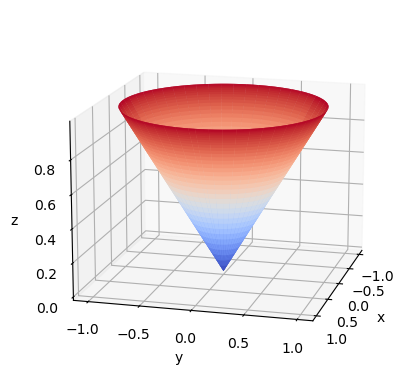

In [462]:
from mpl_toolkits import mplot3d
from matplotlib import cm

def f(x, y):
    return np.sqrt(x ** 2 + y ** 2)

fig = plt.figure()
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:80j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = f(x, y)

ax.plot_surface(x, y, z, cmap=cm.coolwarm)

# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles. 
ax.view_init(azim=15, elev=15)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [464]:
hu = xr.open_dataset("/Users/akbaskind/Desktop/Paleo/fig_lines_sedimentHUcount.nc")

In [466]:
hu['HUrecord']

<xarray.DataArray 'HUrecord' (quantile: 3, year: 1520)>
array([[     nan,      nan,      nan, ..., 7.224769, 7.200358, 7.176103],
       [     nan,      nan,      nan, ..., 7.225376, 7.200897, 7.17661 ],
       [     nan,      nan,      nan, ..., 7.226006, 7.201509, 7.177216]])
Coordinates:
  * year      (year) int64 500 501 502 503 504 505 ... 2015 2016 2017 2018 2019
  * quantile  (quantile) float64 0.025 0.5 0.975